In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import f_class
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

In [3]:
objective = f_class.sin(Noise, Noise_level)
objective = f_class.Ackley_1(Noise, Noise_level)
objective = f_class.Schwefel(Noise, Noise_level, 1)

clean_f = lambda x: f_class.sin().func(x)
clean_f = lambda x: f_class.Ackley_1().func(x)
clean_f = lambda x: f_class.Schwefel(dim=1).func(x)

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
lb = B[:, 0]; ub = B[:, 1]

f = objective.func
print(f( np.array([2]) ))

dim = objective.input_dim
print('dim: ', dim)

[417.00735511]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100

In [5]:
# set seed
seed = 1
def draw(n_random_draws=3):
    X = np.random.uniform(lb, ub, size=(n_random_draws, dim))
    return X, f(X)

def optimize_hyper(lb, ub, sample_size=200):
    
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# # find optimized hyper
# gp = GP_grad(B, Noise, Noise_level, compress=True)

# X = np.asarray(np.random.uniform(lb, ub, size=(1000, dim)))
# gp.set_data(X, f(X))

# (ls, var) = gp.optimize()
# del gp
# (ls, var)

In [7]:
gp = GP_grad(B, Noise, Noise_level, compress=True)

# set optimized hyper
# gp.set_hyper(ls, var)

# put in some random data (let them to be close)
init_size = 2
# X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))
X = np.random.uniform(lb, ub, size=(init_size, dim))

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

array([[ 0.99999937],
       [-0.99999937]])

In [8]:
gp._y, gp.posterior(X)

(array([[ 1.],
        [-1.]]),
 (array([[ 0.99999899],
         [-0.99999899]]),
  array([[1.00999898e-06, 0.00000000e+00],
         [0.00000000e+00, 1.00999898e-06]])))

In [9]:
# Grid -> test points for plotting
n_Grid = 500
Grid = np.linspace(lb, ub, n_Grid).reshape(-1, dim)

In [10]:
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

CubeGrid = gp.compress(Grid)
Kt = gp.cov_RBF(CubeGrid, CubeGrid, gp.get_hyper())
K_11 = gp.K11(CubeGrid)
K_01 = gp.K01(CubeGrid)

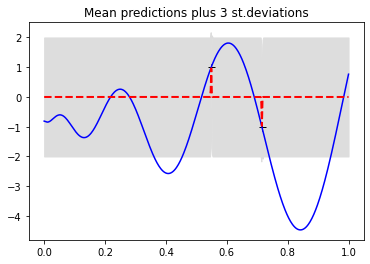

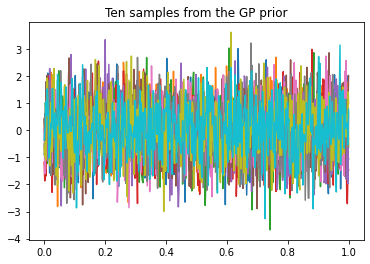

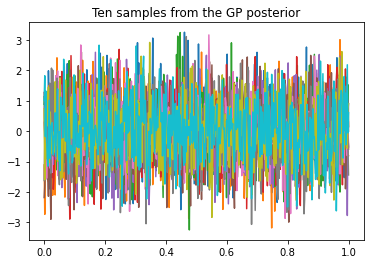

In [11]:
# plot
pl.figure(1)
pl.clf()
pl.plot(gp._X, gp._y, 'k+', ms=7)
pl.plot(CubeGrid, gp._normal(clean_f(Grid)), 'b-')
pl.gca().fill_between(CubeGrid.flat, mu-2*s, mu+2*s, color="#dddddd")

pl.plot(CubeGrid, mu, 'r--', lw=2)
# pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(CubeGrid, f_prior)
pl.title('Ten samples from the GP prior')
# pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(CubeGrid, f_post)
pl.title('Ten samples from the GP posterior')
# pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [12]:
mu_grad, covar_grad = gp.posterior_grad(Grid)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

In [13]:
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

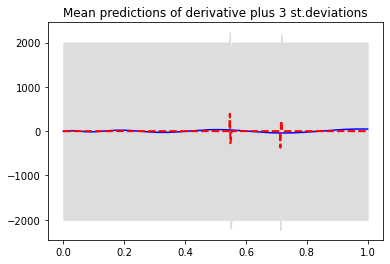

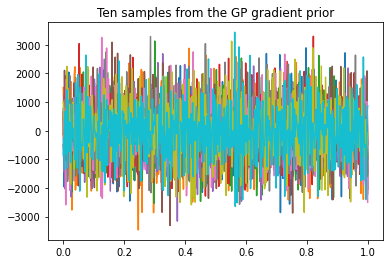

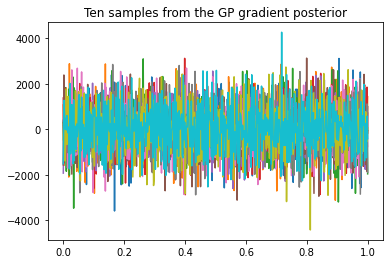

In [14]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(CubeGrid, gp._normal_grad(approx_grad), 'b-')
pl.gca().fill_between(CubeGrid.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

pl.plot(CubeGrid, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(CubeGrid, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(CubeGrid, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

### Gradient Descent 

In [15]:
n_iter = 40
lr = 0.001
lr_init = 15
alpha = 0.5

history = []
history_lr = []


w = X[0].reshape(1, -1) 
# arg_min = np.argmin(f(X))
# w = X[arg_min].reshape(1, -1) # min value to start
w

array([[0.39050803]])

In [16]:
gp.posterior_grad(w), gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))

((array([[0.]]), array([[999999.60230978]])), array([22.45982018]))

In [17]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
lr = 0.01
mt = np.array([0])
vt = np.array([0])

In [18]:
gp.X

array([[0.39050803],
       [1.72151493]])

`Backtrack`
$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

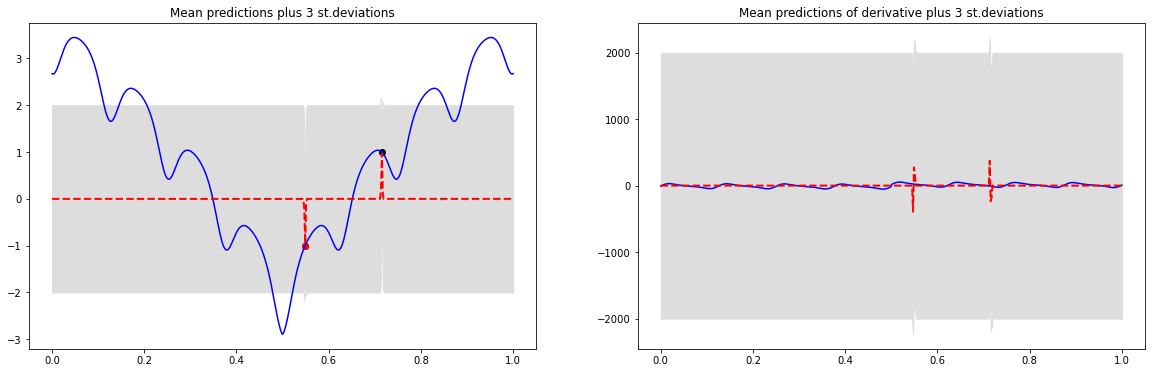

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[999999.60230978]]
actual df [22.45982018]
  # Optimal (ls, var) =  (0.001, 2.232160090901636)


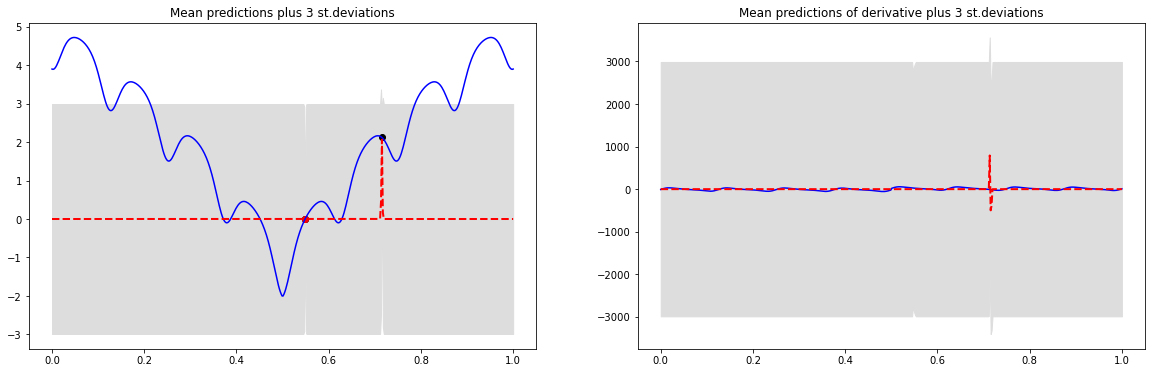

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[2232160.09090164]]
actual df [23.82223674]


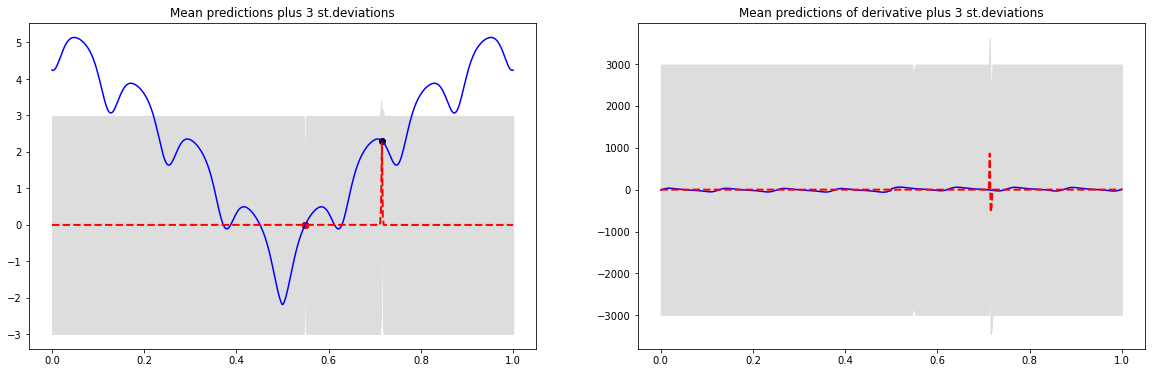

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[2232160.09090164]]
actual df [25.93436646]


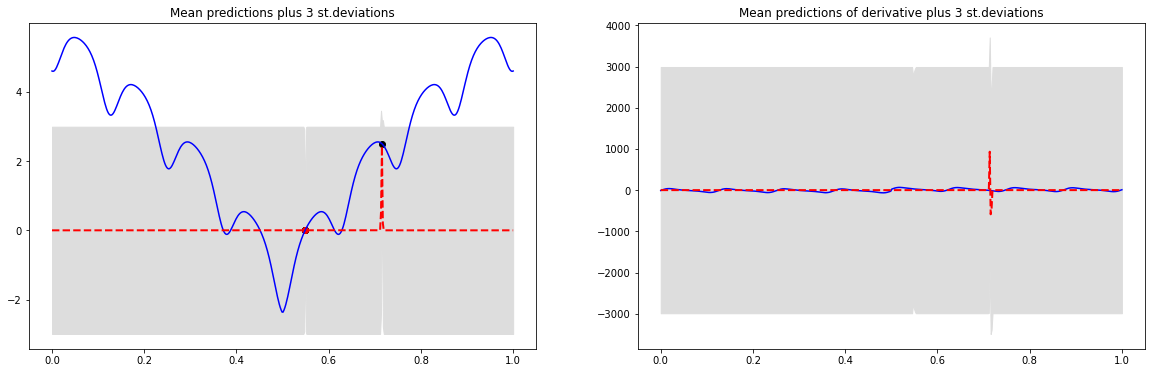

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[2232160.09090164]]
actual df [28.07477523]


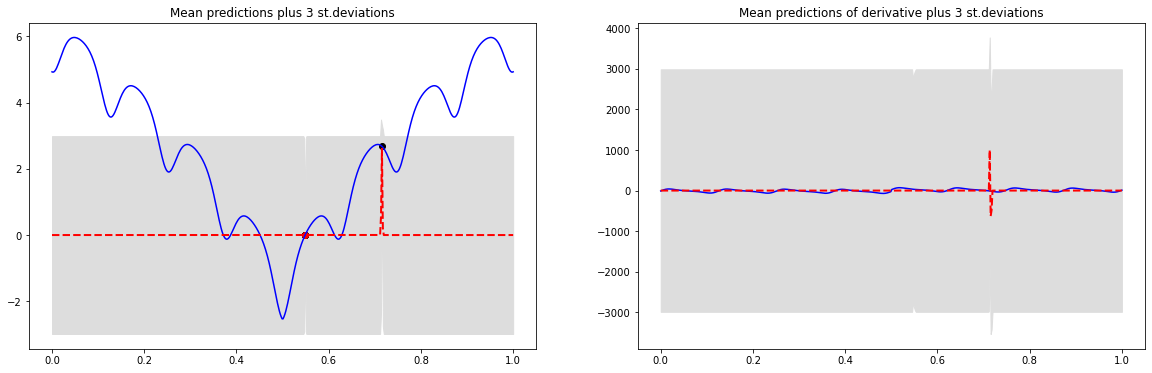

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[2232160.09090164]]
actual df [30.13301082]


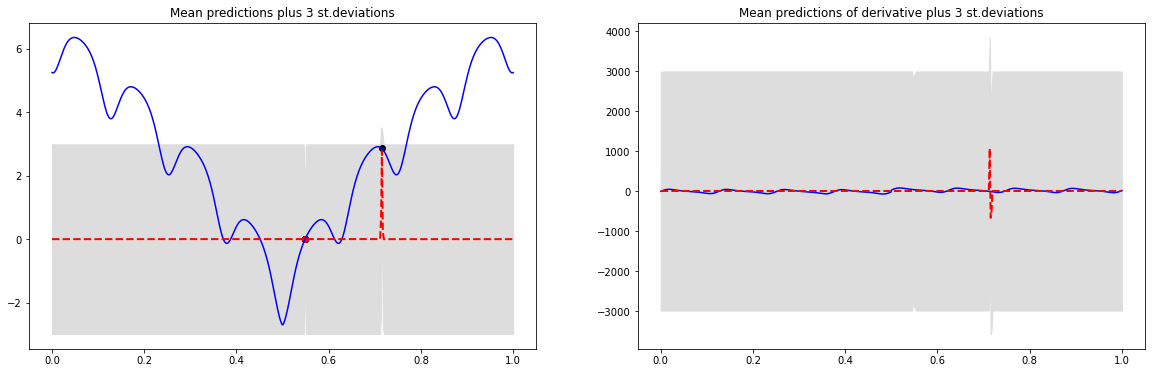

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[2232160.09090164]]
actual df [32.09214118]
  # Optimal (ls, var) =  (0.001, 9.236881418817644)


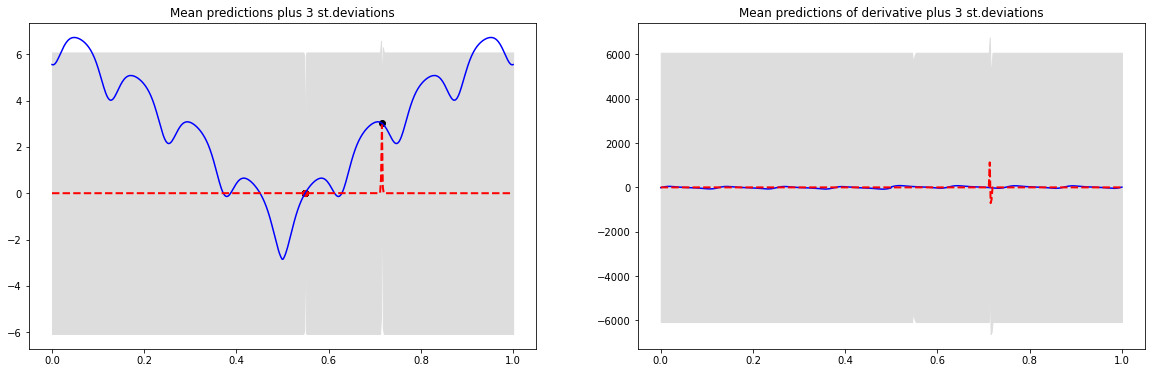

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9236881.41881764]]
actual df [33.9560564]


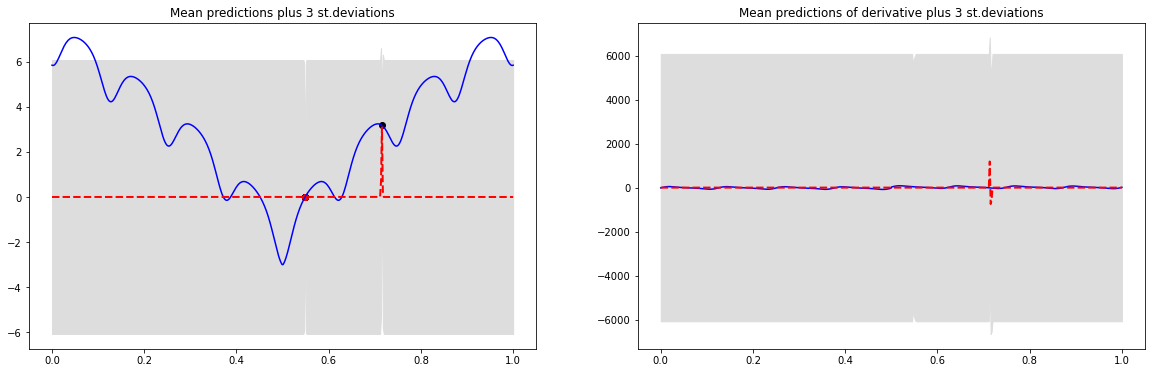

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9236881.41881764]]
actual df [35.7333551]


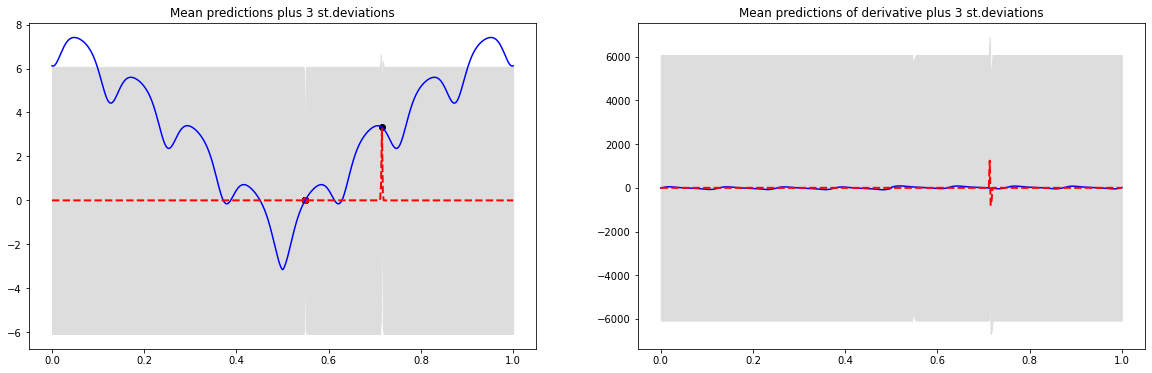

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9236881.41881764]]
actual df [37.43303364]


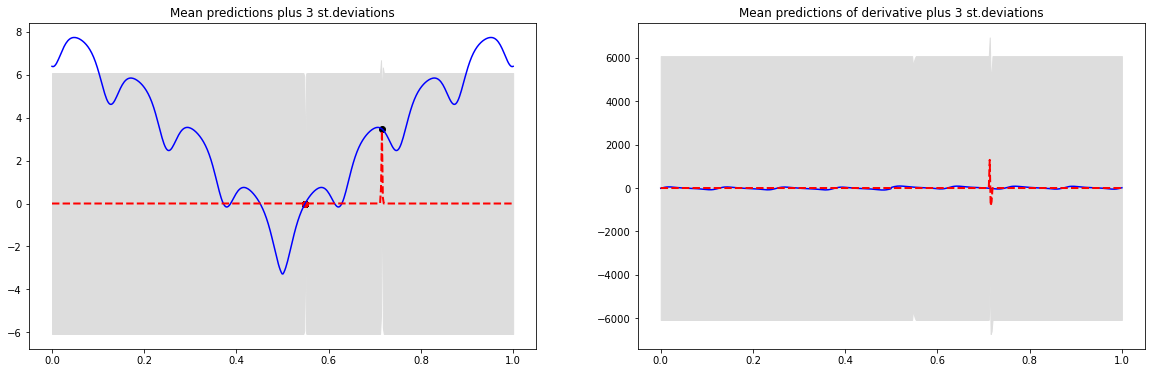

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9236881.41881764]]
actual df [39.06330319]


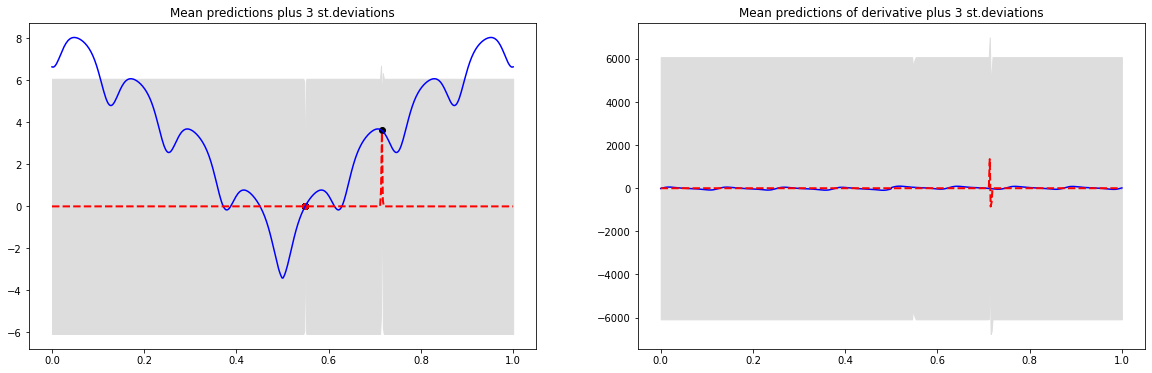

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9236881.41881764]]
actual df [40.6313435]
  # Optimal (ls, var) =  (0.001, 8.155633216306004)


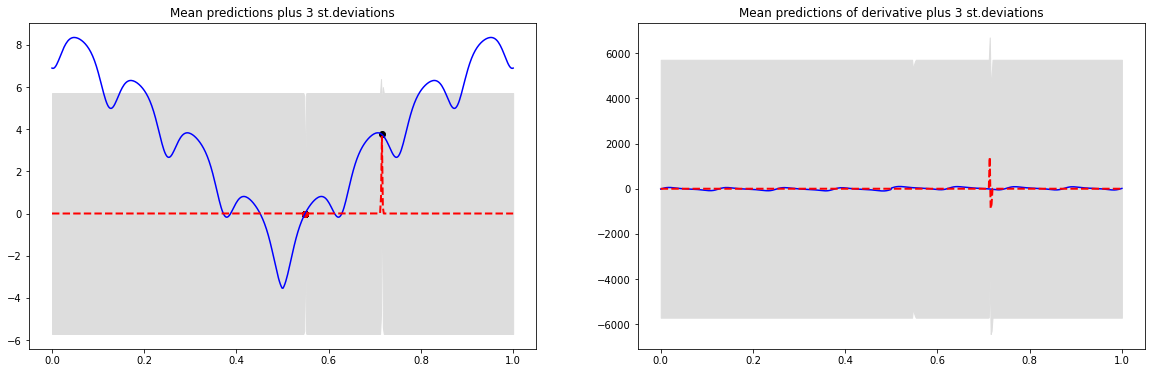

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[8155633.216306]]
actual df [42.1433455]


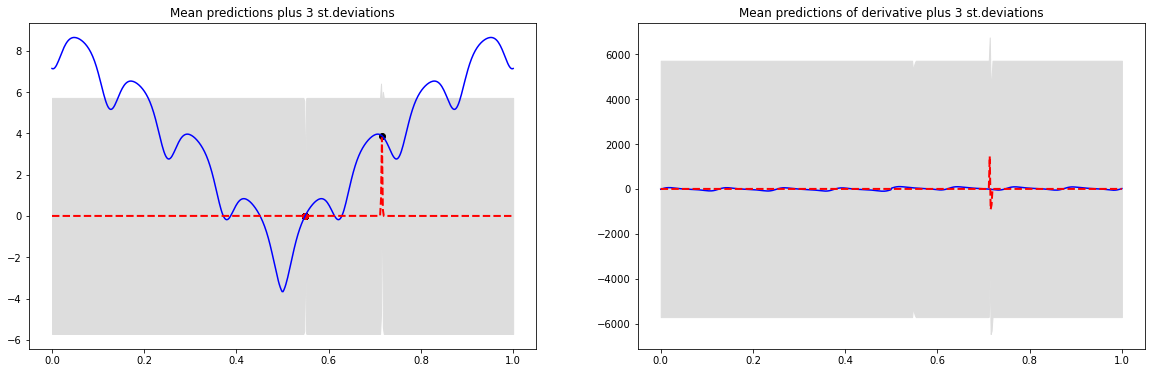

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[8155633.216306]]
actual df [43.60463332]


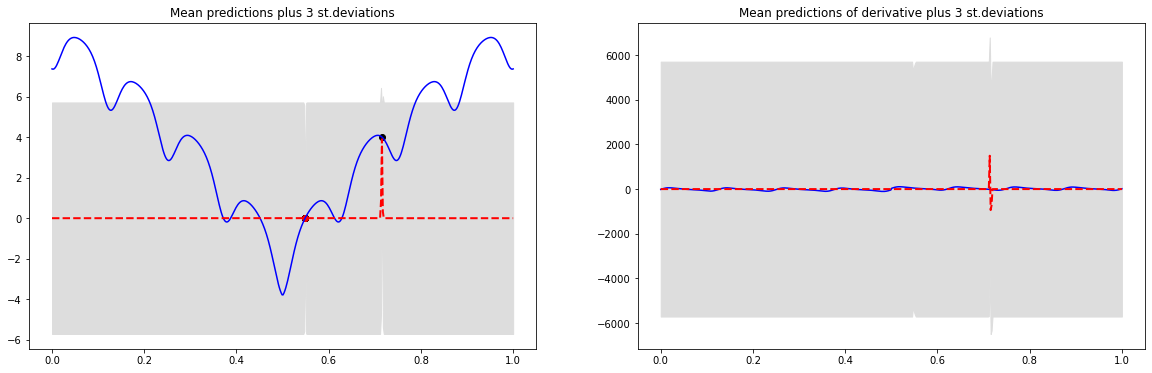

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[8155633.216306]]
actual df [45.01979577]


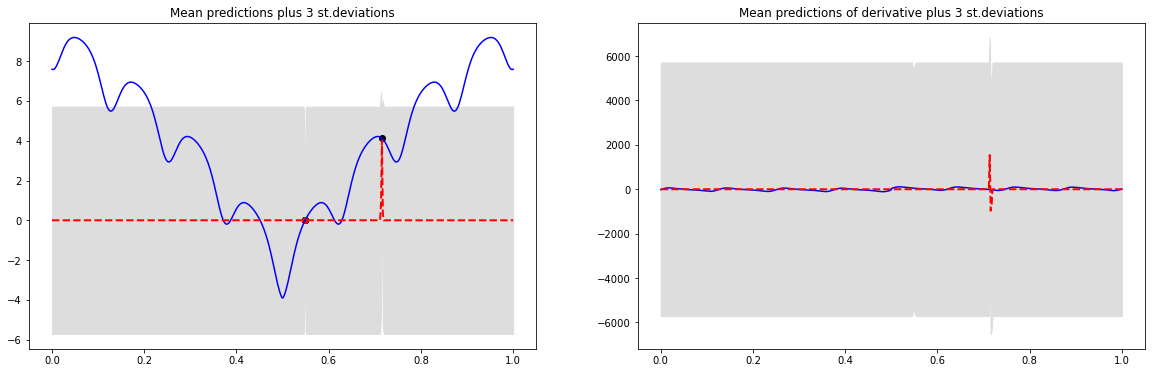

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[8155633.216306]]
actual df [46.39280508]


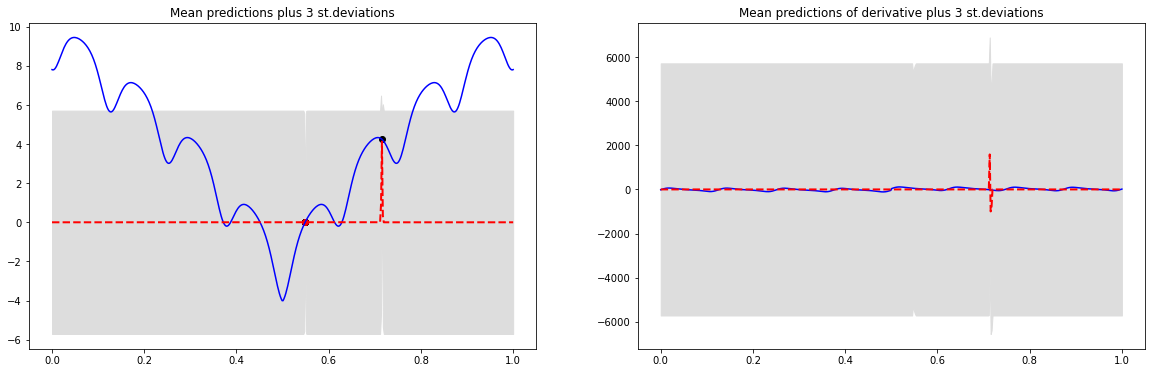

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[8155633.216306]]
actual df [47.72711789]
  # Optimal (ls, var) =  (0.001, 9.5377166307009)


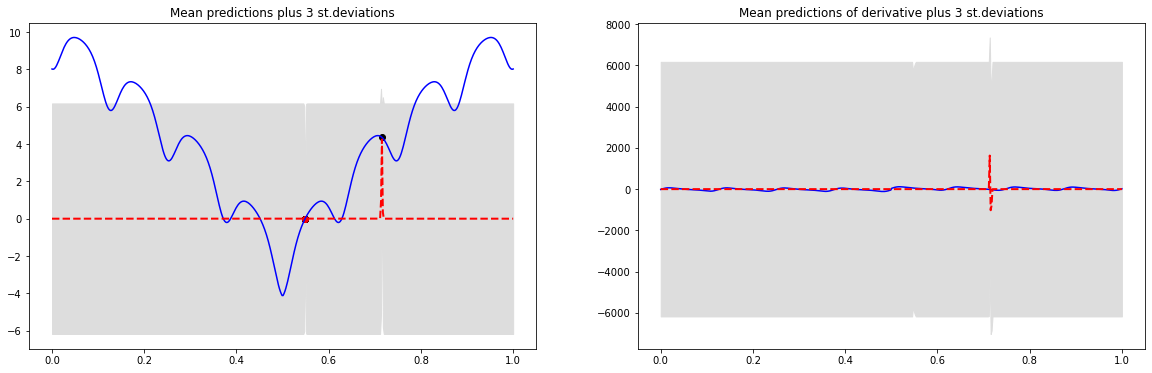

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9537716.6307009]]
actual df [49.02575874]


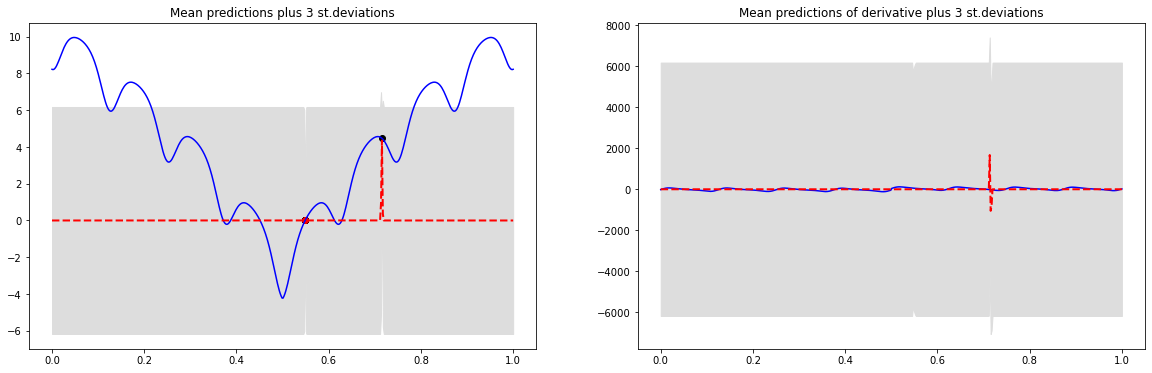

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9537716.6307009]]
actual df [50.29138866]


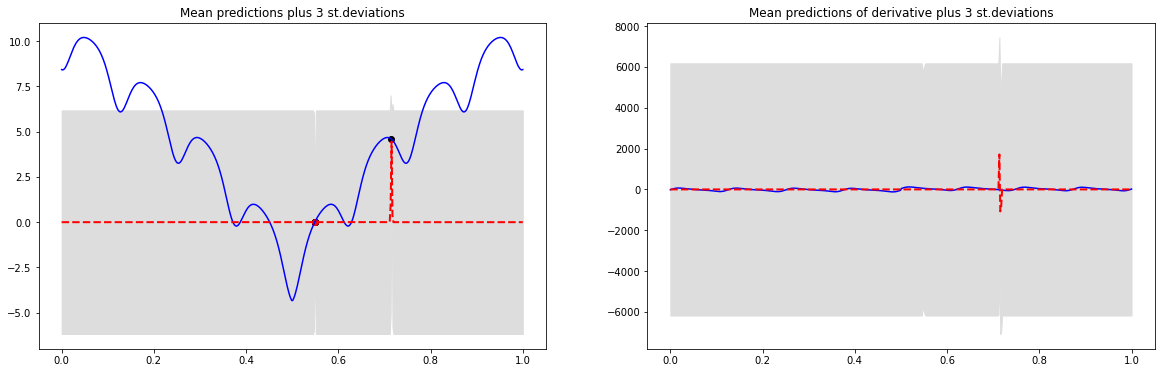

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9537716.6307009]]
actual df [51.5263613]


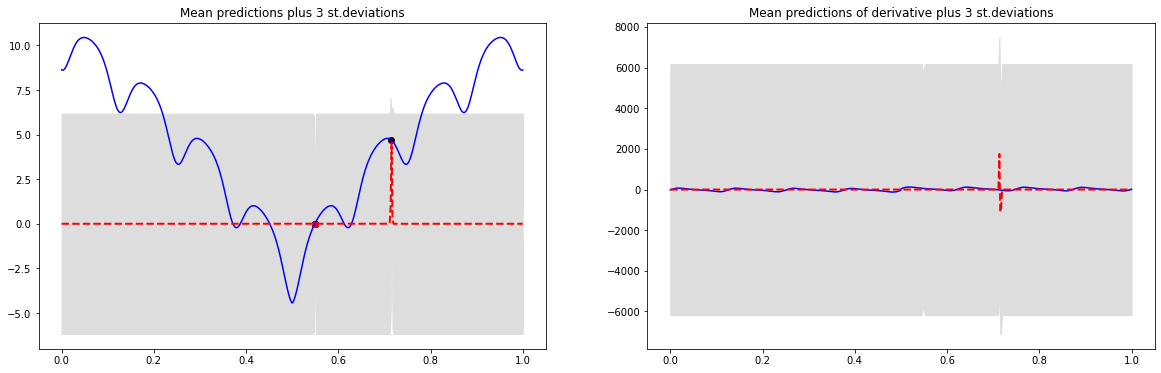

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9537716.6307009]]
actual df [52.73276893]


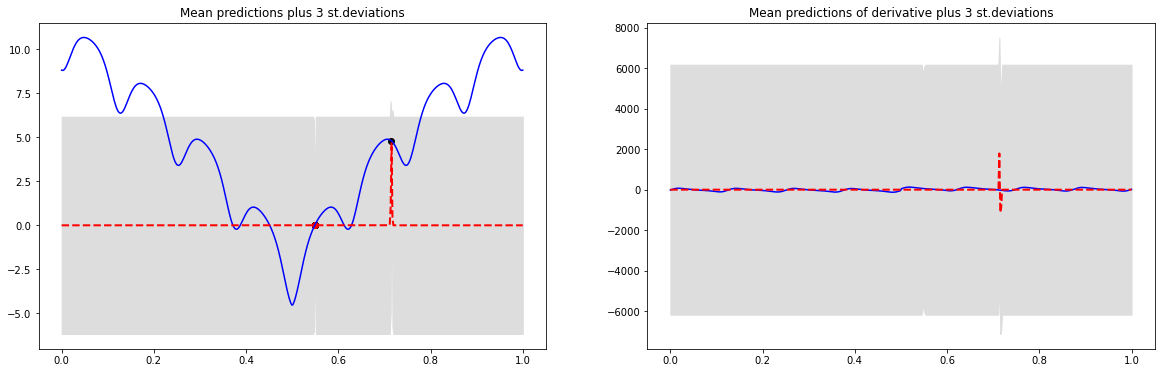

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[0.]], s.d. [[9537716.6307009]]
actual df [53.91248033]
  # Optimal (ls, var) =  (0.0058662833220176165, 11.797632036627823)


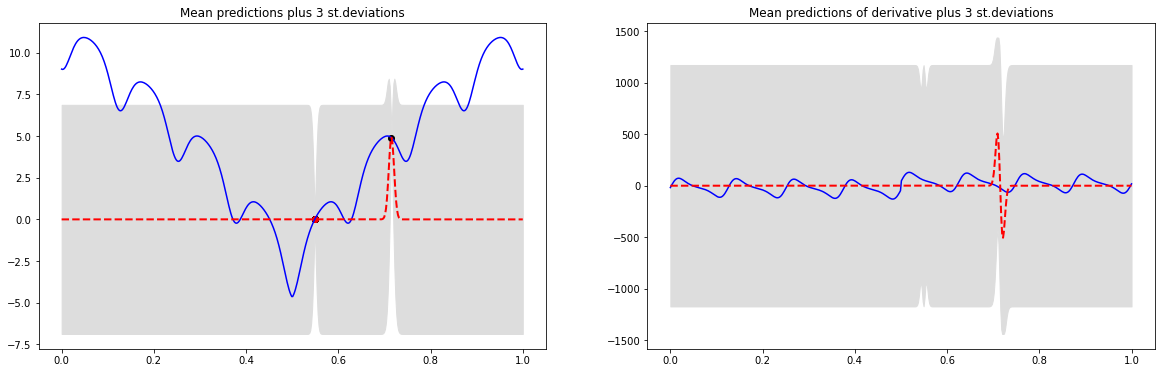

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.11298719e-171]], s.d. [[342822.0742622]]
actual df [55.06717215]


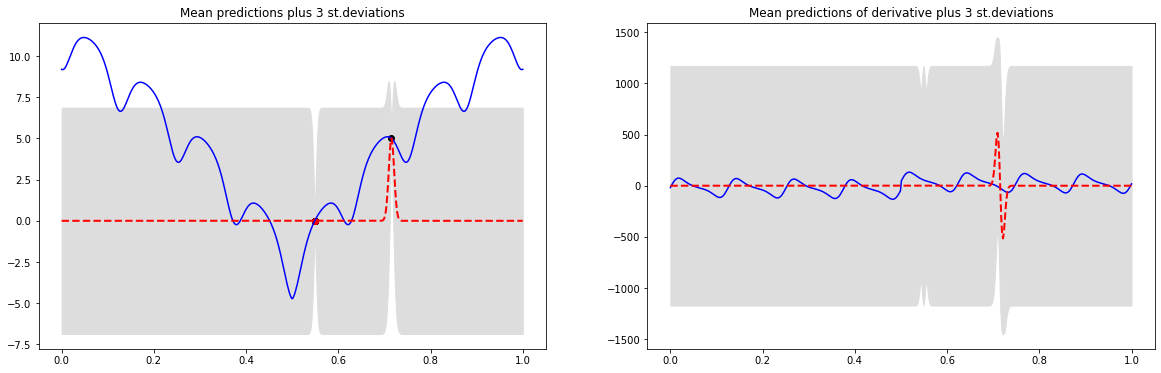

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.21801752e-171]], s.d. [[342822.0742622]]
actual df [56.19835495]


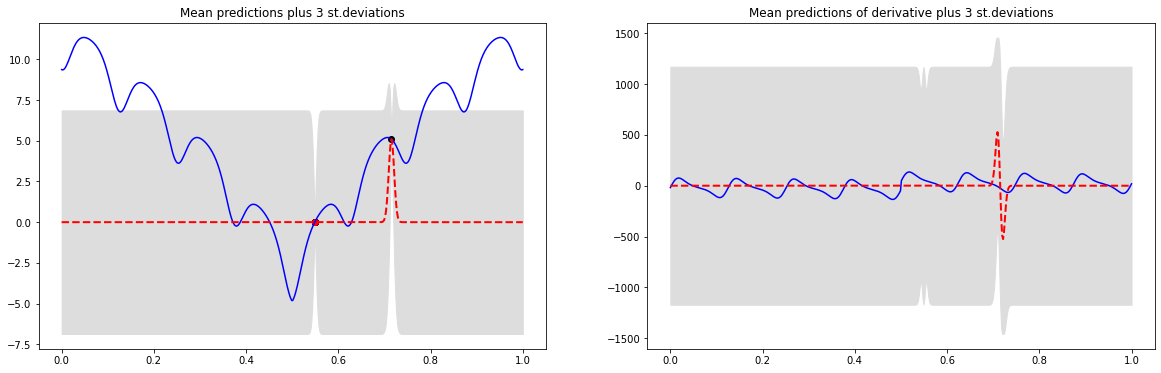

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.32099189e-171]], s.d. [[342822.0742622]]
actual df [57.30739497]


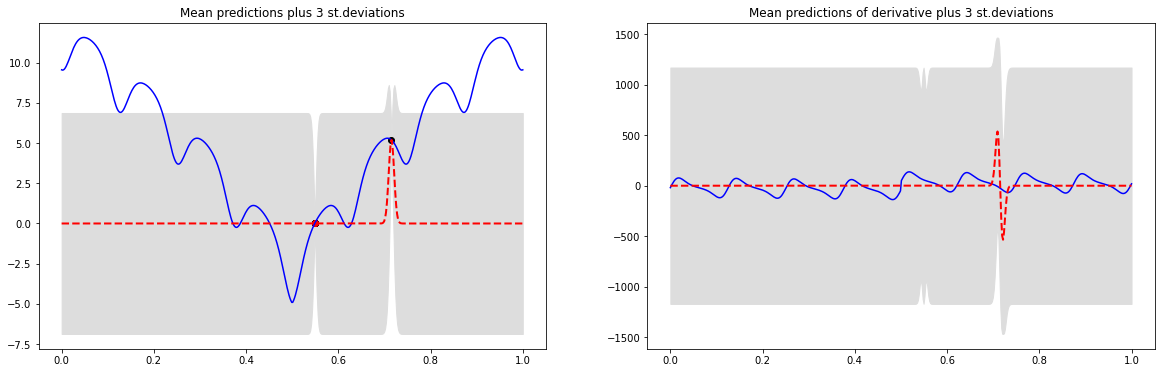

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.42202546e-171]], s.d. [[342822.0742622]]
actual df [58.39553248]


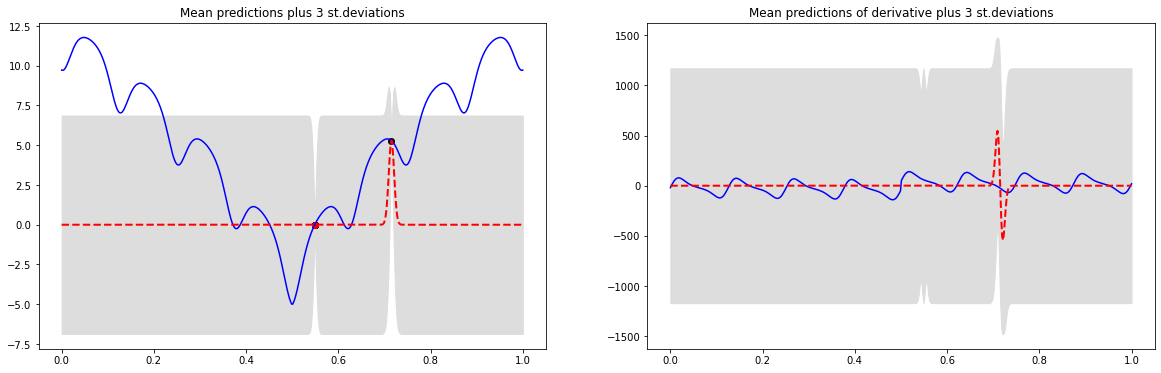

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.52122314e-171]], s.d. [[342822.0742622]]
actual df [59.46389726]
  # Optimal (ls, var) =  (0.0122331935974908, 17.48987606812287)


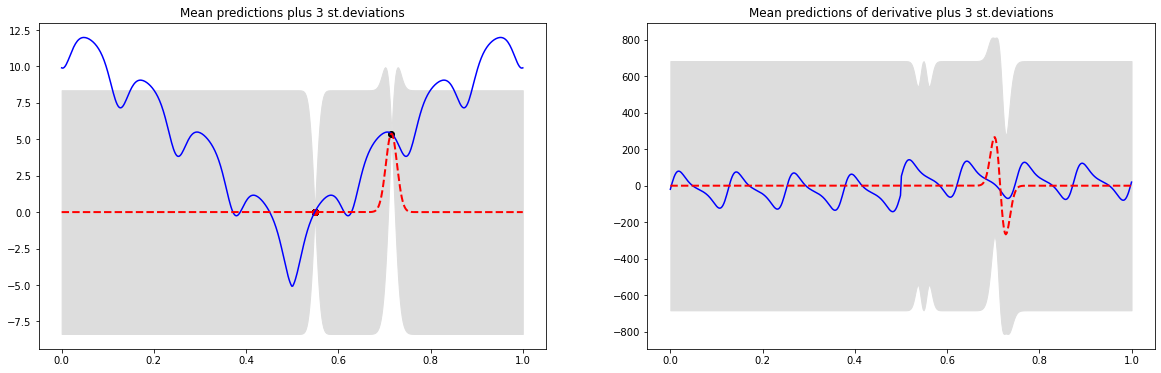

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[4.09066938e-37]], s.d. [[116871.0738783]]
actual df [60.51352174]


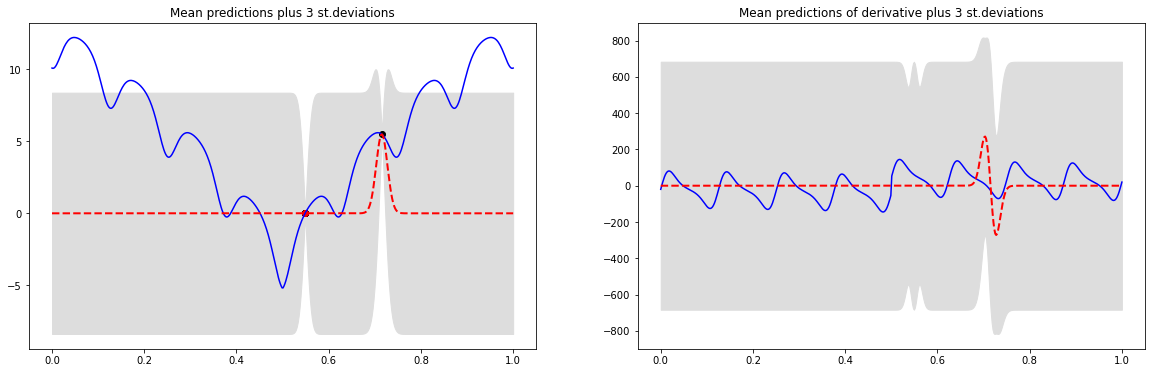

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[4.16042036e-37]], s.d. [[116871.0738783]]
actual df [61.54535222]


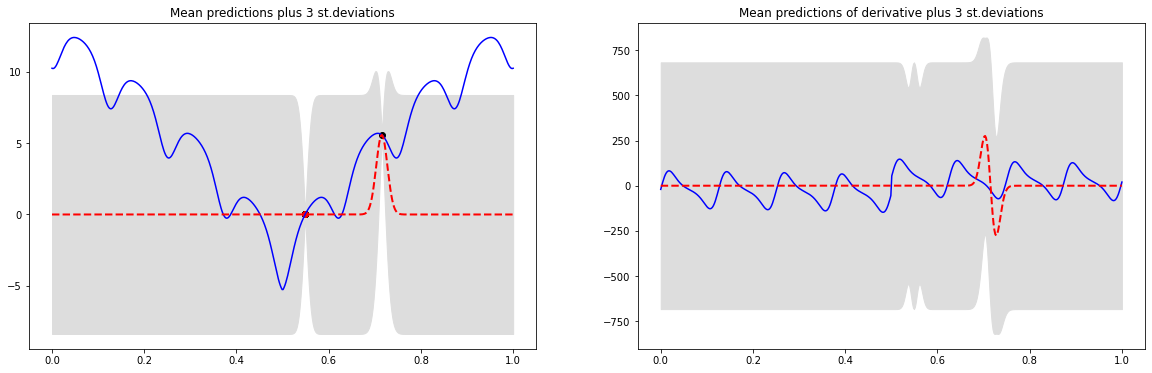

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[4.22902728e-37]], s.d. [[116871.0738783]]
actual df [62.56025857]


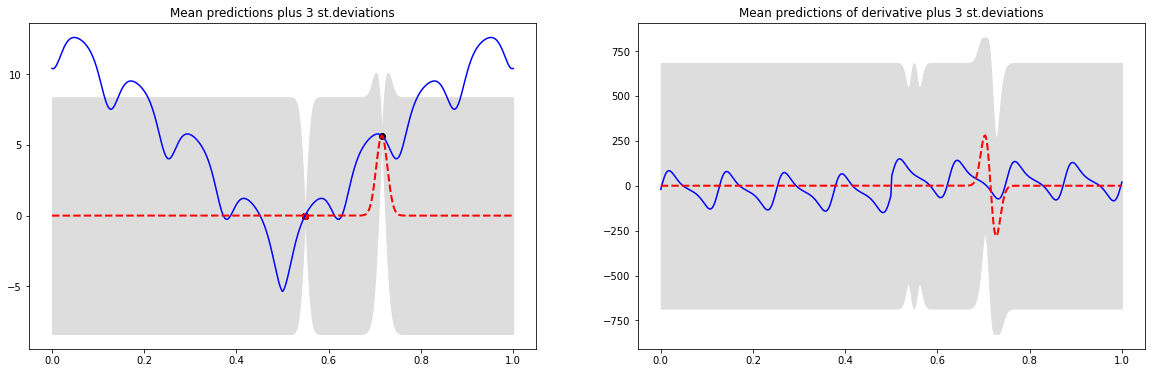

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[4.29654434e-37]], s.d. [[116871.0738783]]
actual df [63.55904245]


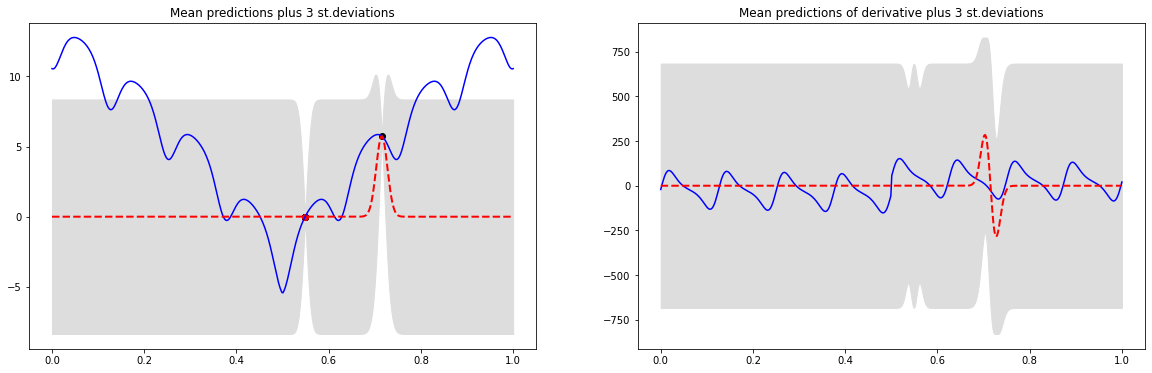

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[4.36302159e-37]], s.d. [[116871.0738783]]
actual df [64.5424446]
  # Optimal (ls, var) =  (0.02101802441784592, 14.354741410182623)


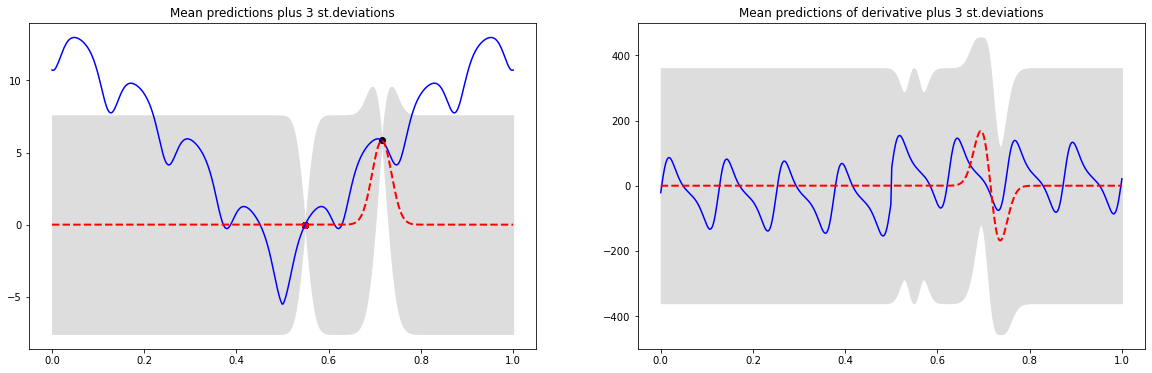

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.43496566e-11]], s.d. [[32494.62945266]]
actual df [65.51115058]


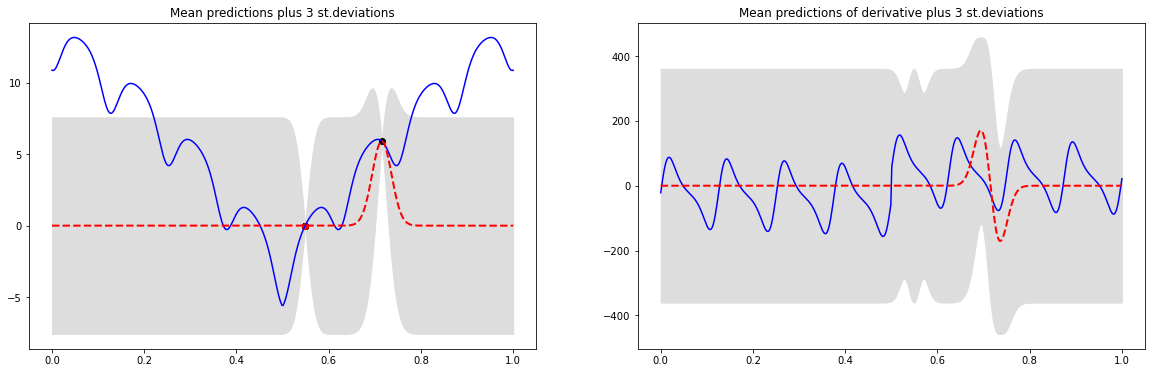

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.51416701e-11]], s.d. [[32494.62945266]]
actual df [66.46579489]


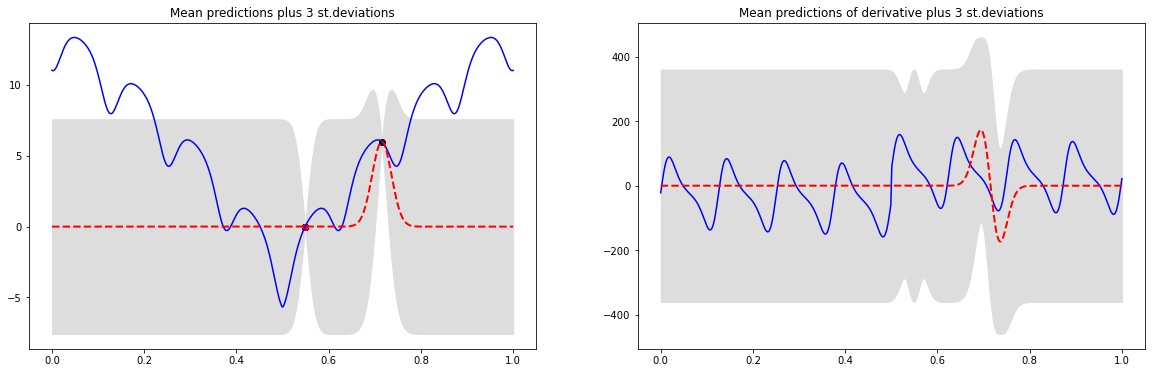

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.59225565e-11]], s.d. [[32494.62945266]]
actual df [67.40697877]


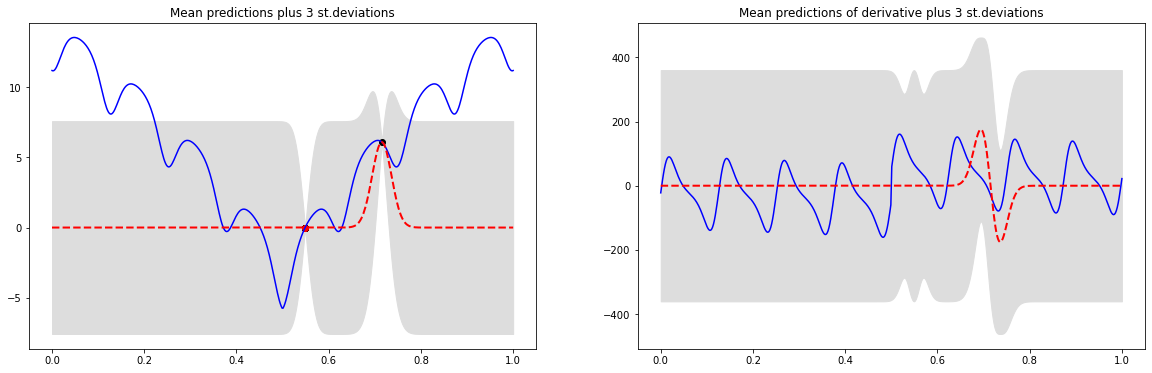

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.66928049e-11]], s.d. [[32494.62945266]]
actual df [68.33524762]


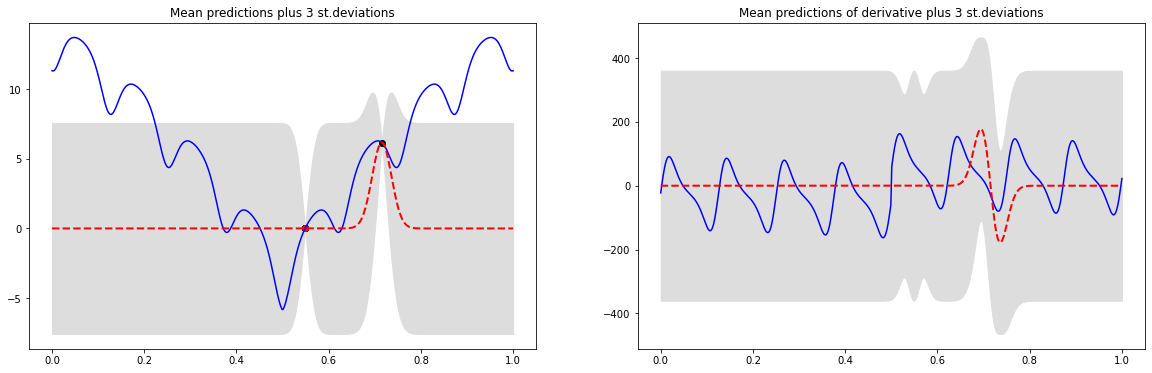

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[5.74528792e-11]], s.d. [[32494.62945266]]
actual df [69.25111503]
  # Optimal (ls, var) =  (0.008280227743147135, 30.21926291708271)


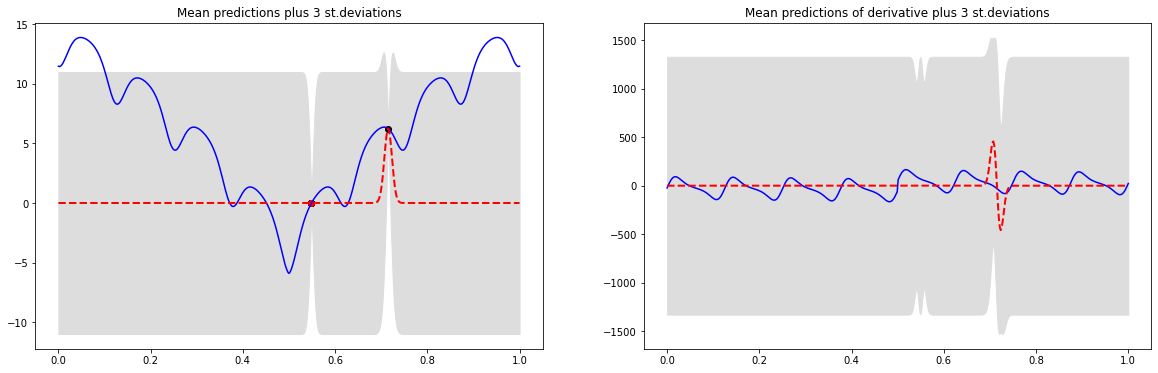

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[1.15337815e-14]], s.d. [[440757.0860939]]
actual df [70.155065]


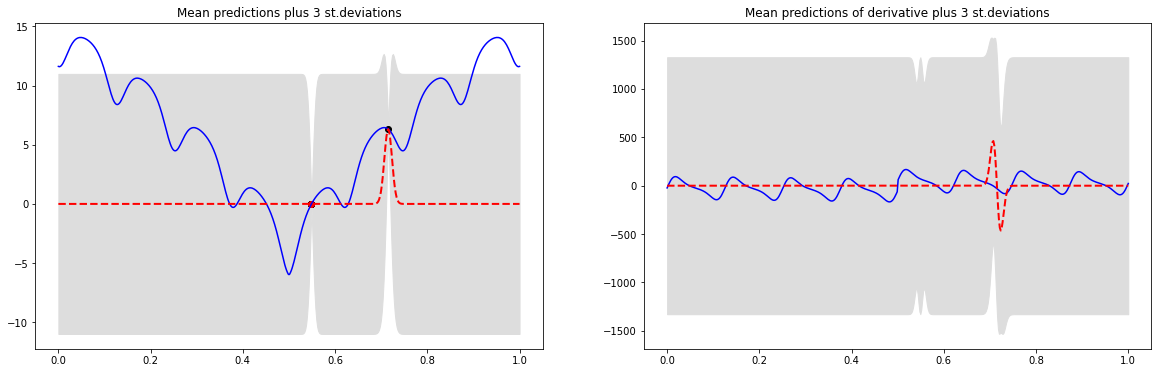

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[1.66945003e-14]], s.d. [[440757.0860939]]
actual df [71.04754986]


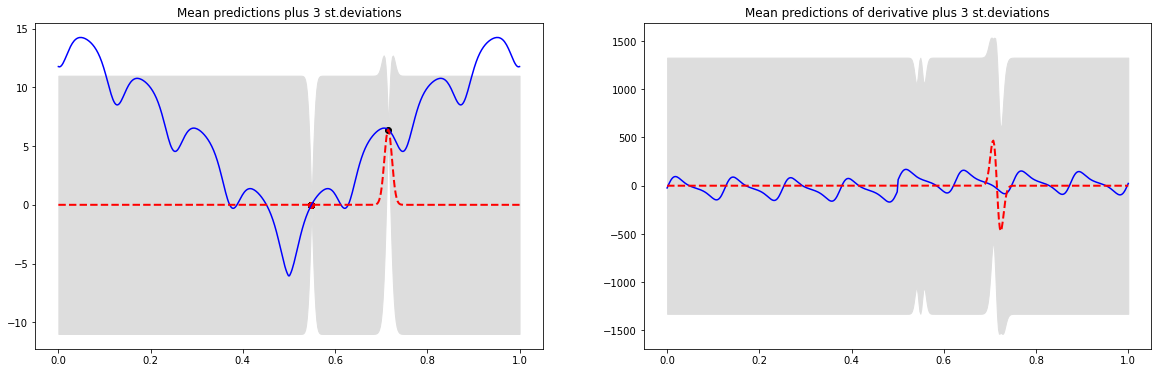

w:  [[0.5488135]]
lr:  [[5.e-05]]
df: [[2.17175301e-14]], s.d. [[440757.0860939]]
actual df [71.92899372]


In [19]:
v = np.array([[0]])
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)
    
    # joint MVN
    K = gp.cov_RBF(gp._X, gp._X, gp.get_hyper())
    K_ = gp.cov_RBF(CubeGrid, CubeGrid, gp.get_hyper())
    K_11 = gp.K11(CubeGrid)
    K_01 = gp.K01(CubeGrid)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(gp._X, gp._y, 'ko')
    ax1.plot(gp.compress(w), gp._normal(f(w)), 'ro')
    
    ax1.plot(CubeGrid.flat, gp._normal(clean_f(Grid)), 'b-')
    ax1.fill_between(CubeGrid.flat, mu-2*s, mu+2*s, color="#dddddd")

    ax1.plot(CubeGrid, mu, 'r--', lw=2)
#     fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')

    # plot derivative
    ax2.plot(CubeGrid.flat, gp._normal_grad(approx_grad), 'b-')
    ax2.fill_between(CubeGrid.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

    ax2.plot(CubeGrid.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')

    pl.show()  

    # 1. gradient descent
    lr = 1e-3
    m, v = gp.posterior_grad(w)
    lr = np.clip(lr / v, 5e-5, 0.005)
    w = gp._unwrap(np.clip(gp.compress(w) - lr * gp.grad(w), gp._B[:, 0], gp._B[:, 1]))
    
    #     2. nesterov
#     lr = 0.01
#     v = 0.9*v + lr*grad(gp, w-0.9*v)
#     w = np.clip(w - v, lb, ub)
    
    # 3. Adam
    # approximate first and second moment
#     gt = grad(gp, w)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * lr * mhat/(np.sqrt(vhat) + epsilon)
#     w = w + delta_w
    
    print('w: ', gp.compress(w))
    print('lr: ', lr)
    m, v = gp.posterior_grad(w)
    print('df:', m, end=', ')
    print('s.d.', v)
    print('actual df', gp._normal_grad(optimize.approx_fprime(w[0], lambda x: clean_f(x).item(), eps)) )
#     print('desc:', -gt)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    if i % 5 == 1:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

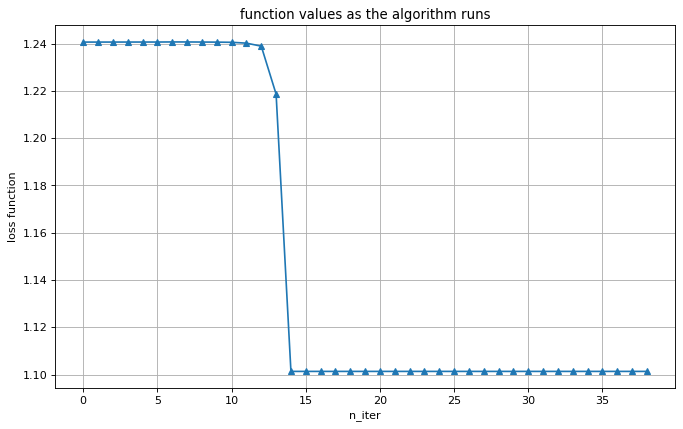

In [51]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [21]:
# plot lr
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### Thompson Sampling

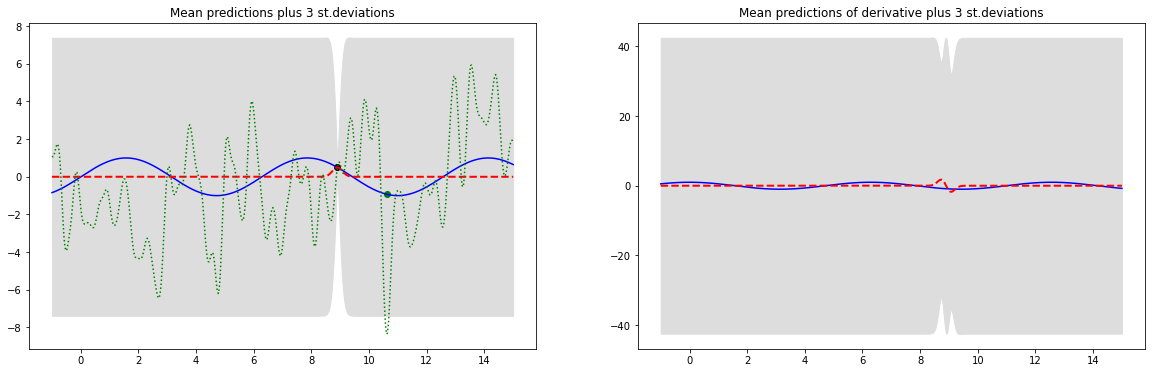

w:  [10.60721443]


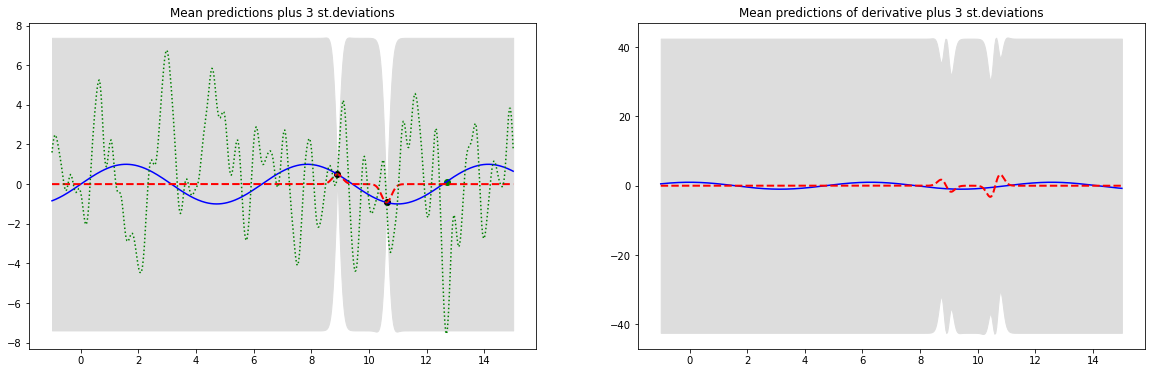

w:  [12.69138277]


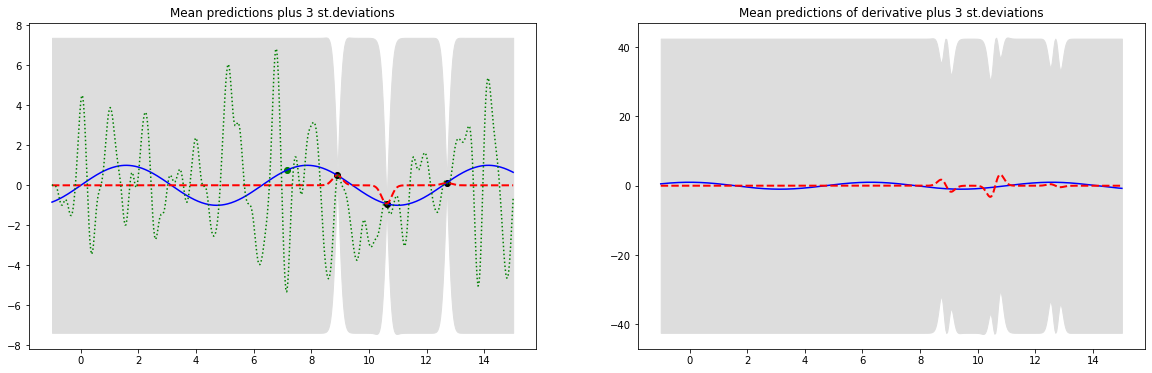

w:  [7.14428858]


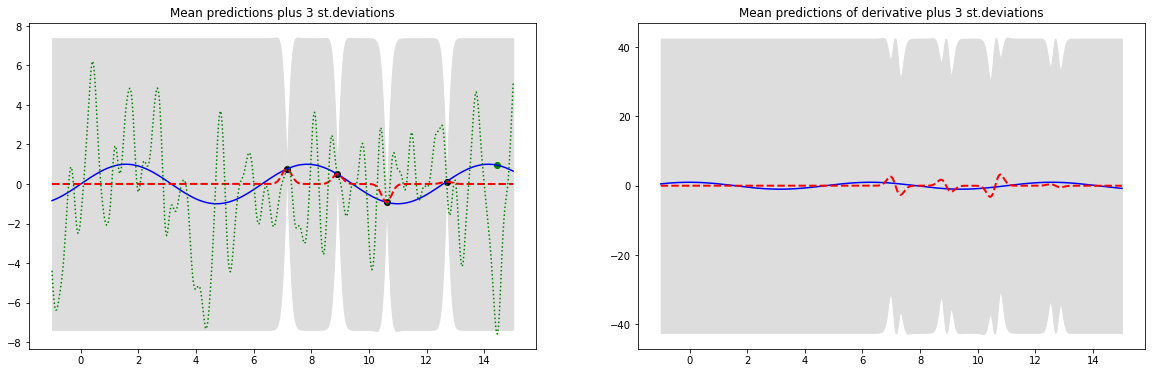

w:  [14.45490982]


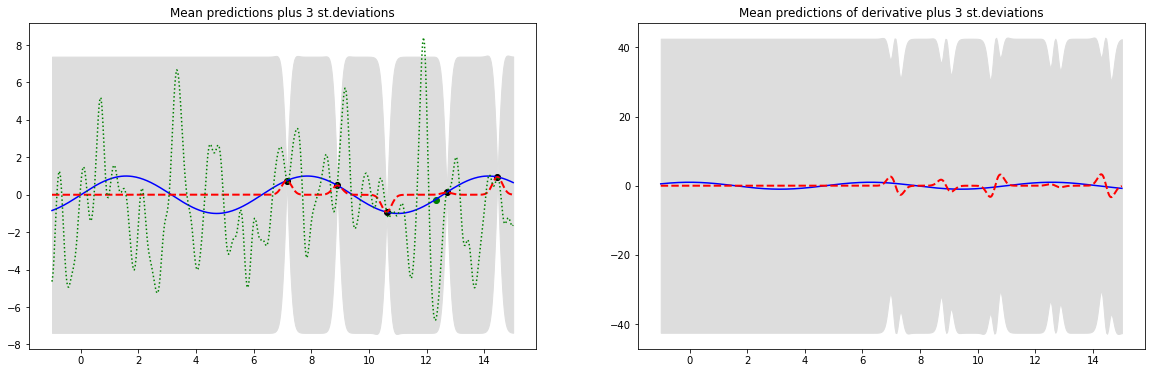

w:  [12.30661323]


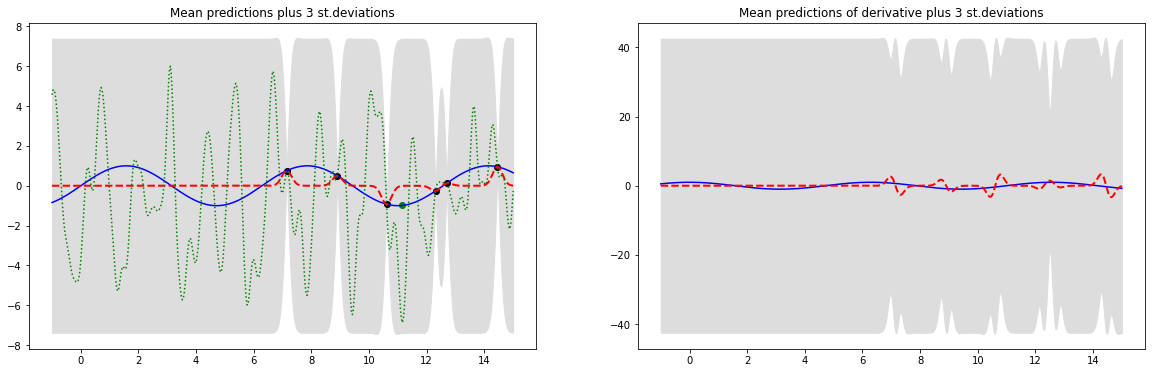

w:  [11.15230461]


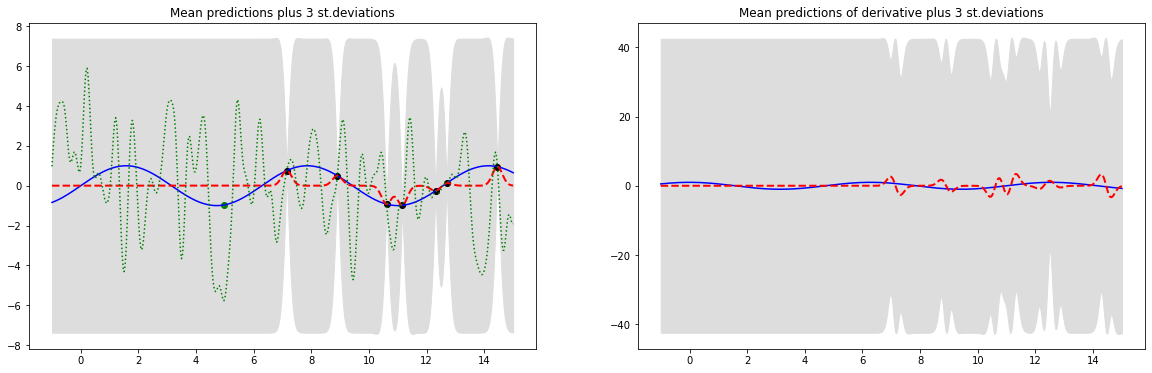

w:  [4.96392786]


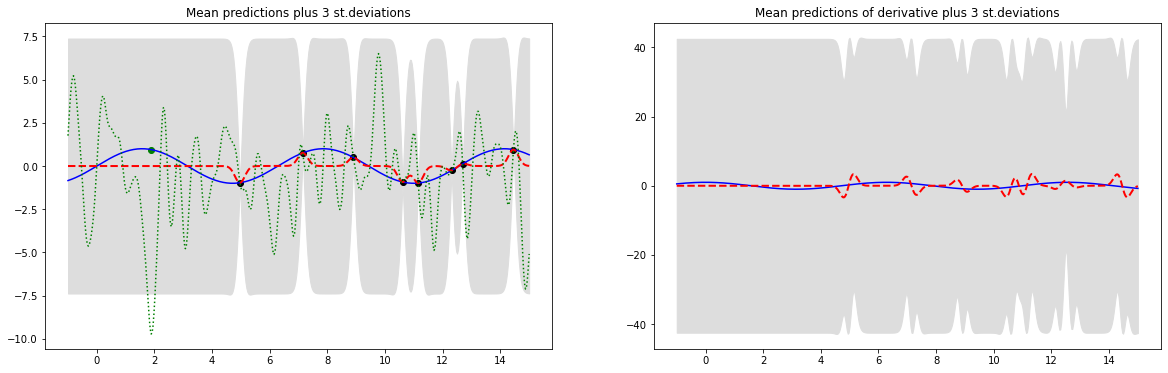

w:  [1.88577154]


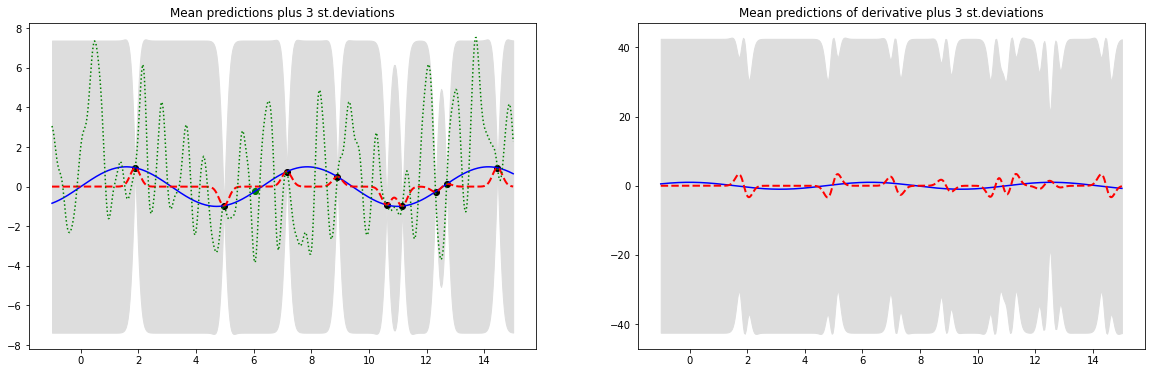

w:  [6.05410822]


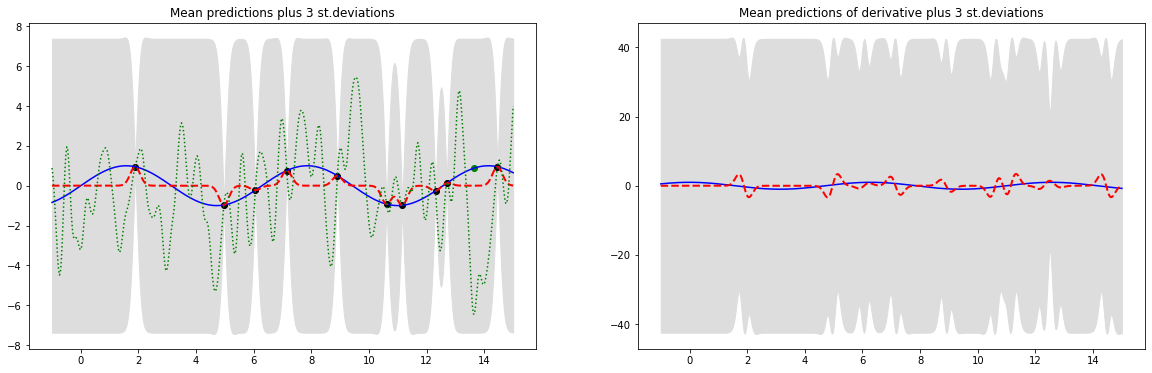

w:  [13.65330661]


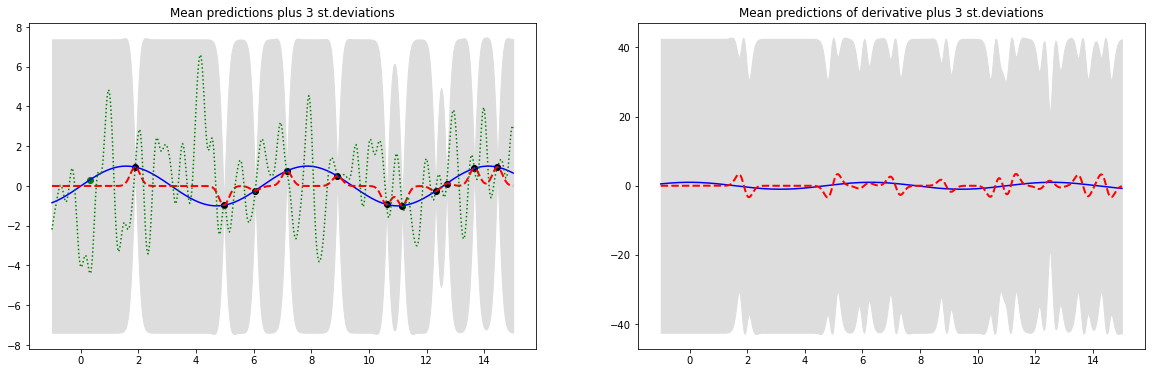

w:  [0.31462926]


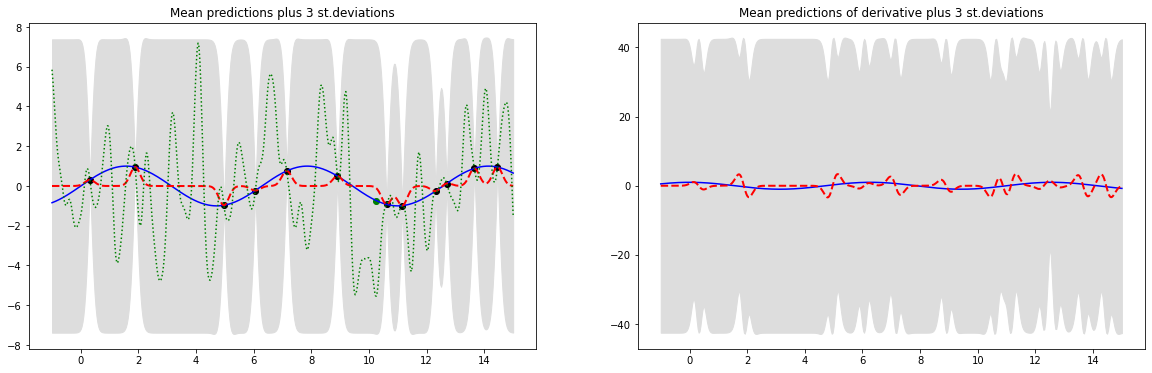

w:  [10.25450902]


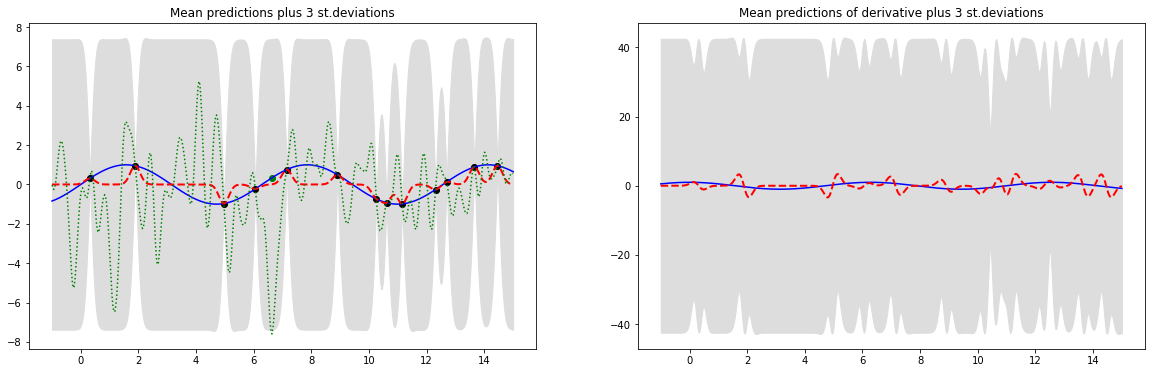

w:  [6.63126253]


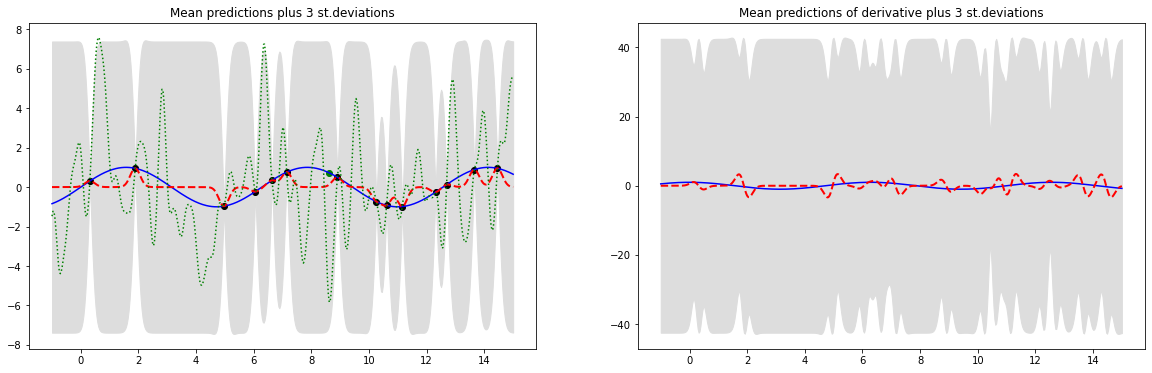

w:  [8.61923848]


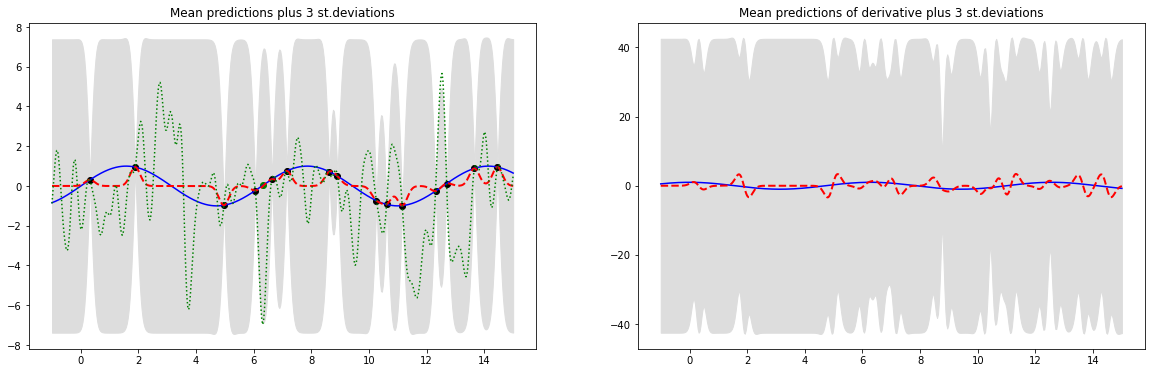

w:  [6.31062124]


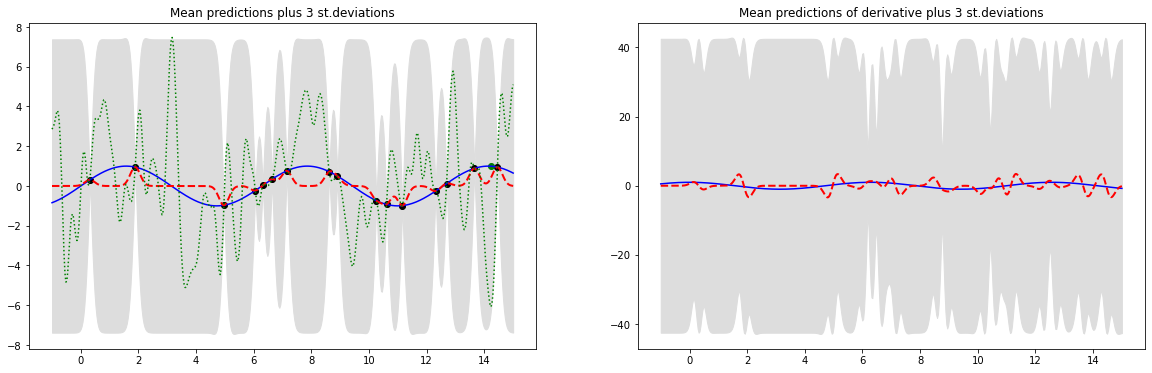

w:  [14.23046092]


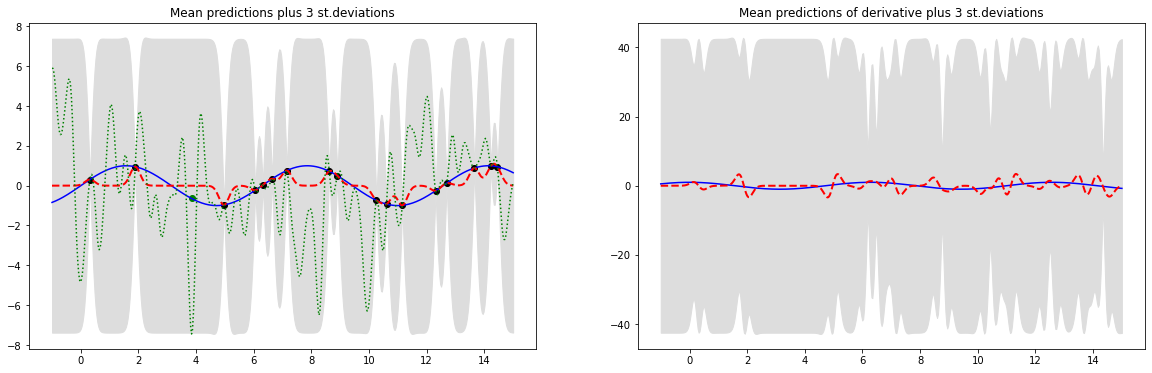

w:  [3.84168337]


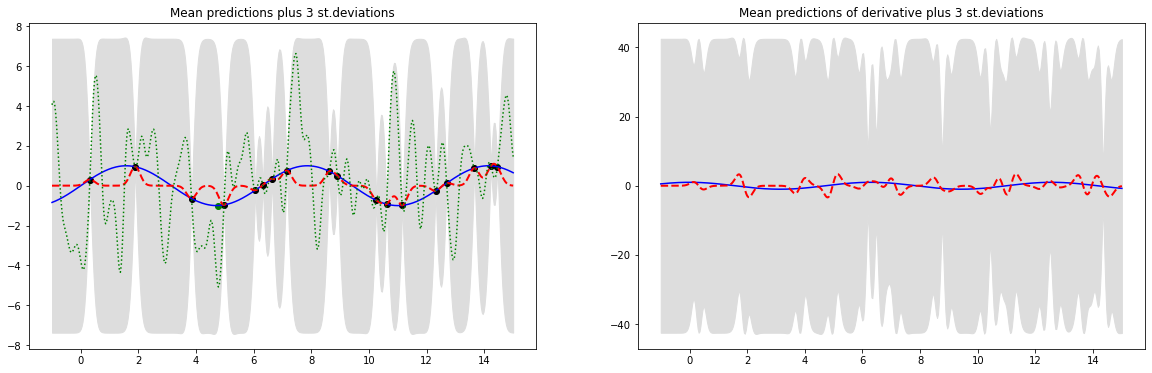

w:  [4.77154309]


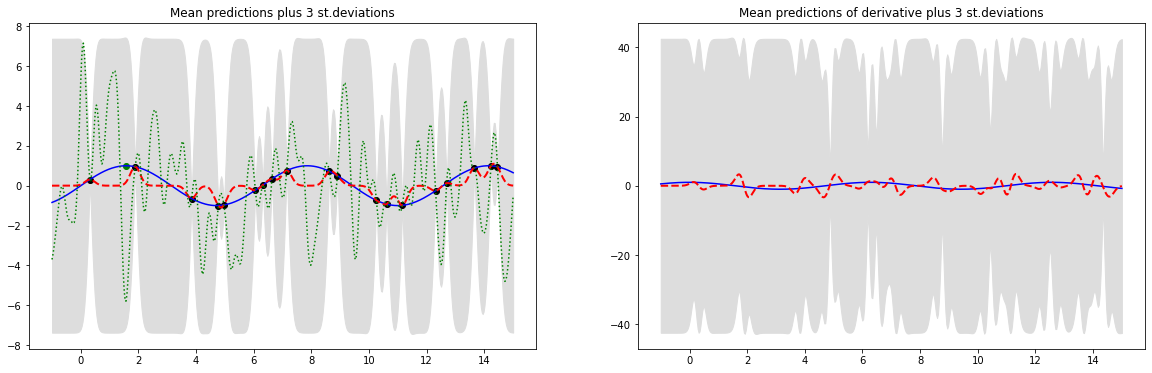

w:  [1.56513026]


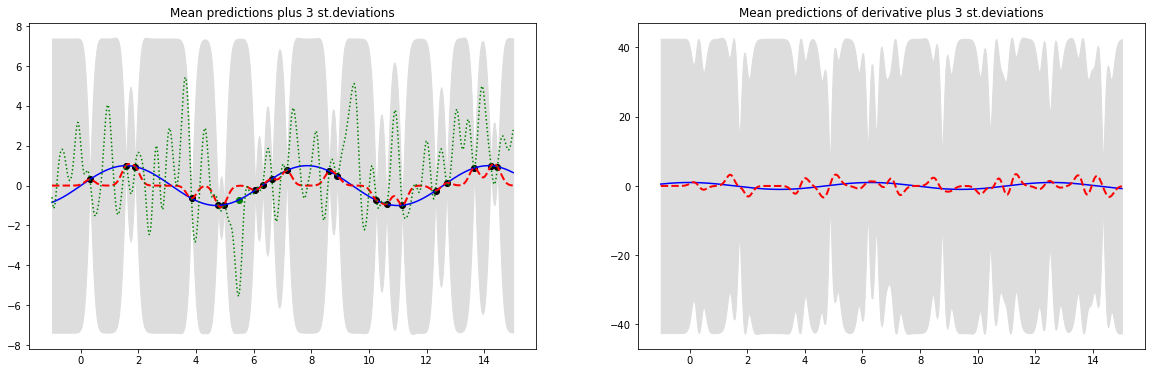

w:  [5.47695391]


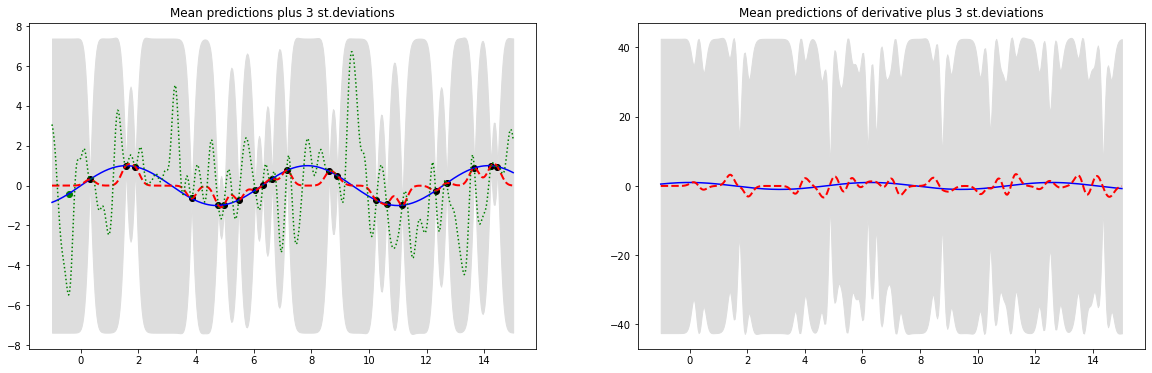

w:  [-0.42284569]


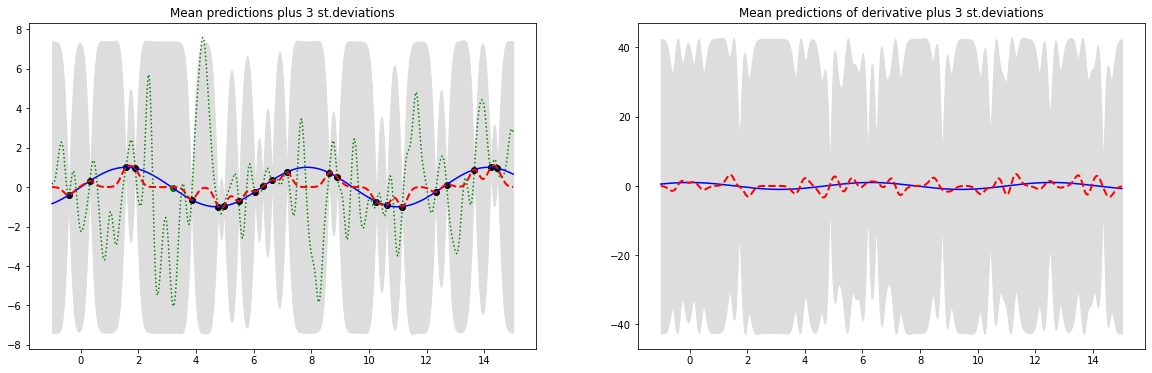

w:  [3.2004008]


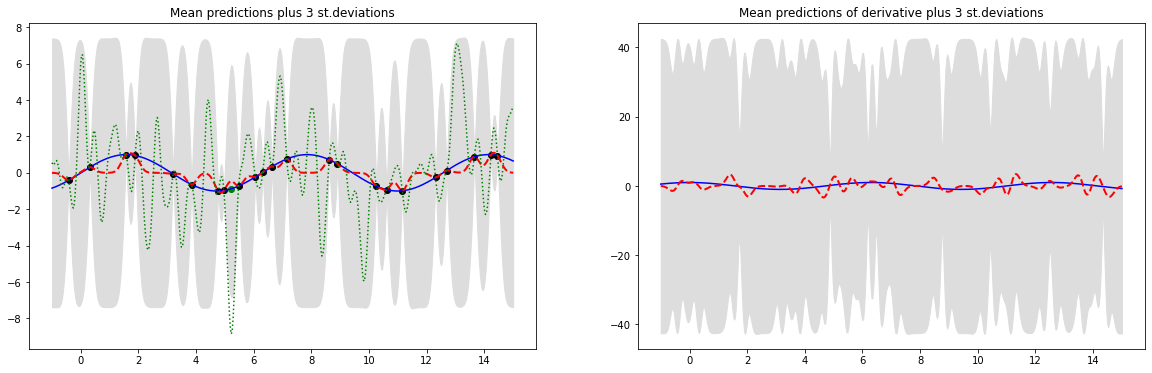

w:  [5.22044088]


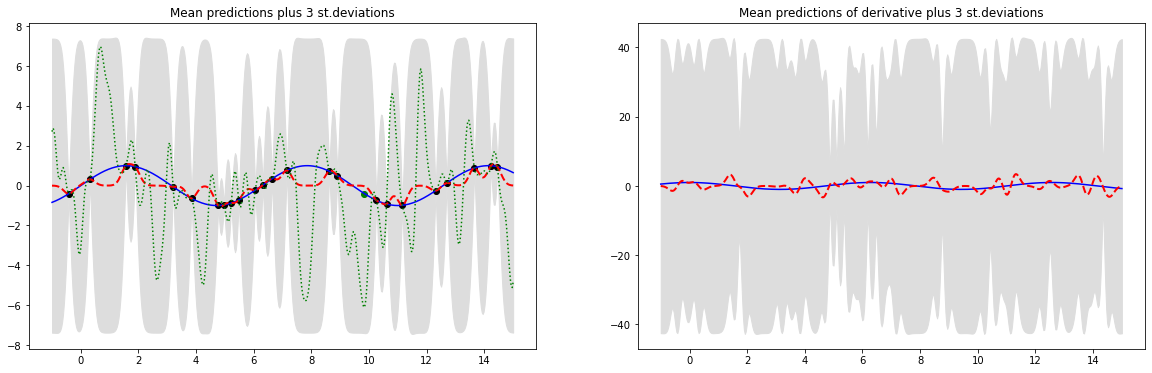

w:  [9.83767535]


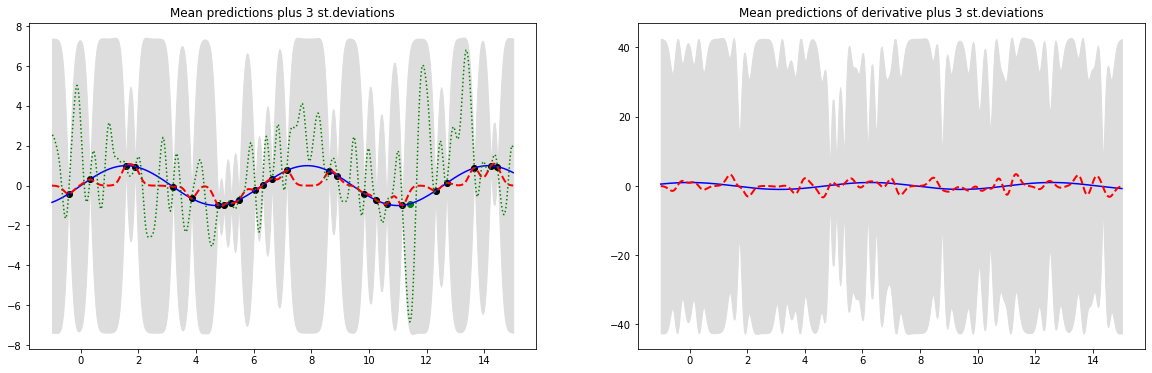

w:  [11.40881764]


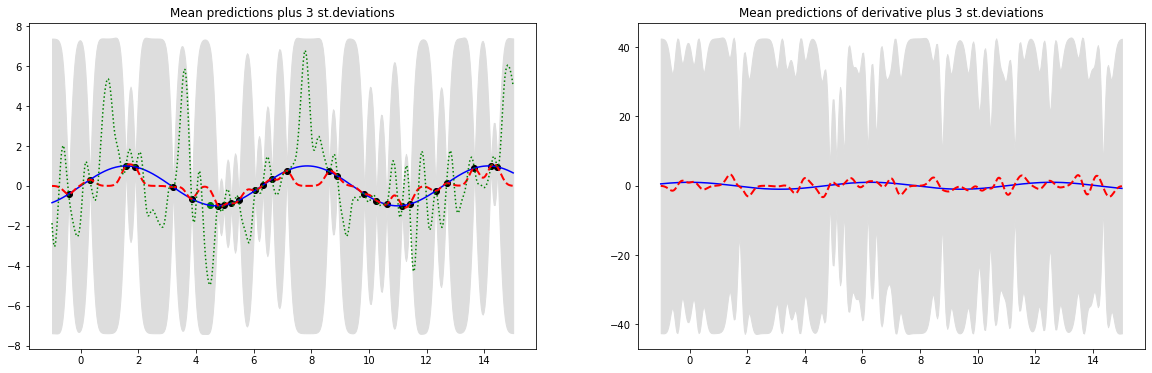

w:  [4.48296593]


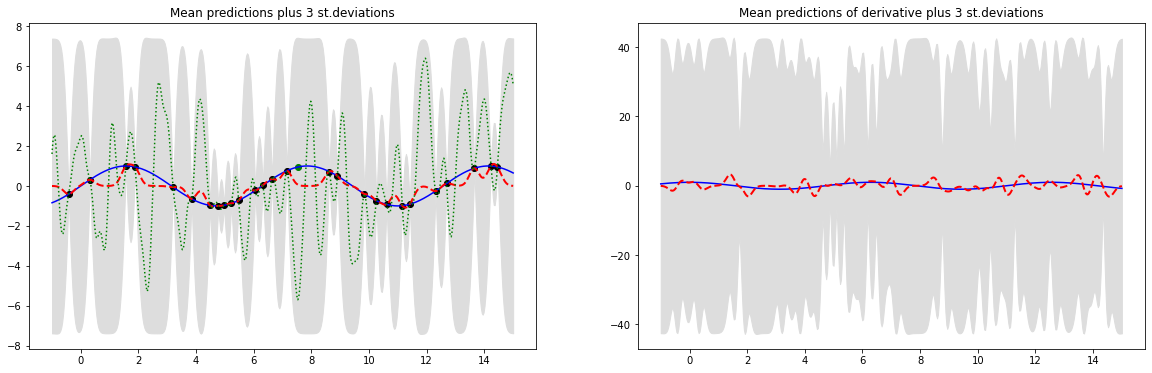

w:  [7.52905812]


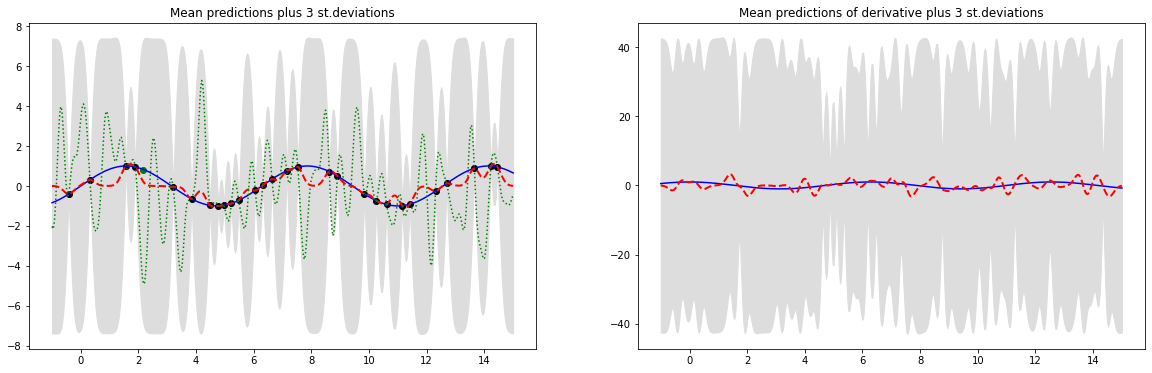

w:  [2.1743487]


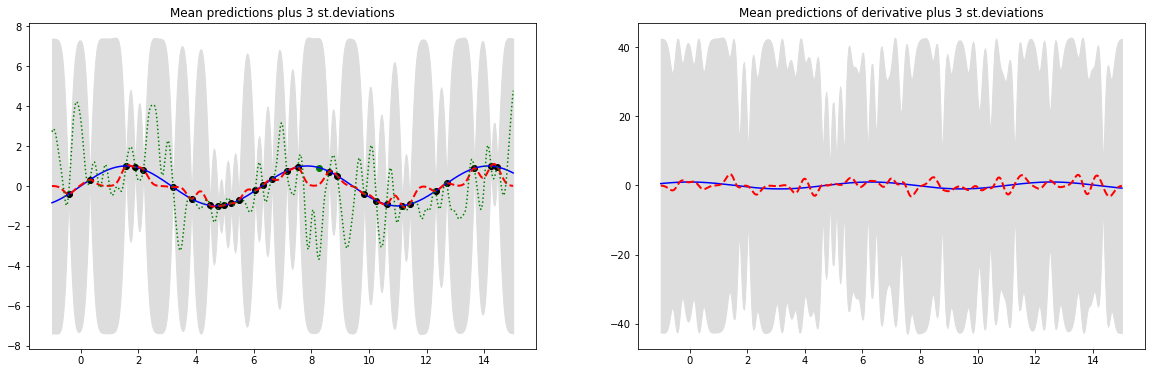

w:  [8.26653307]


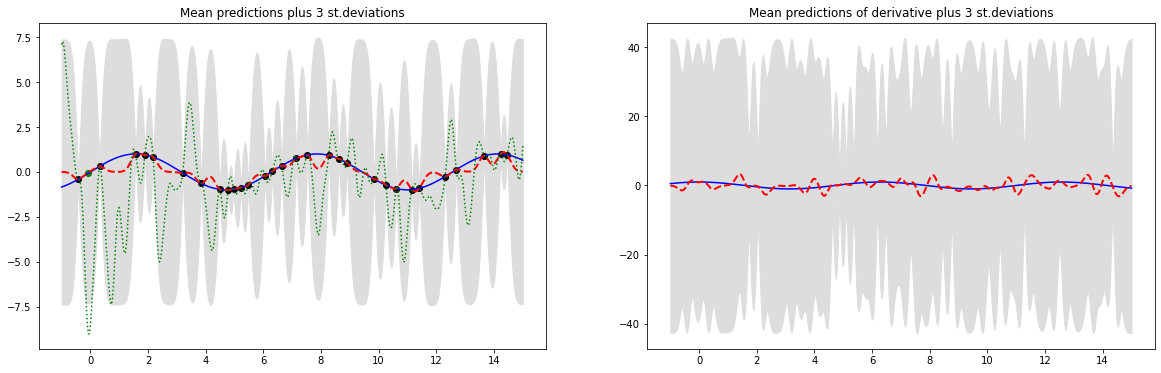

w:  [-0.07014028]


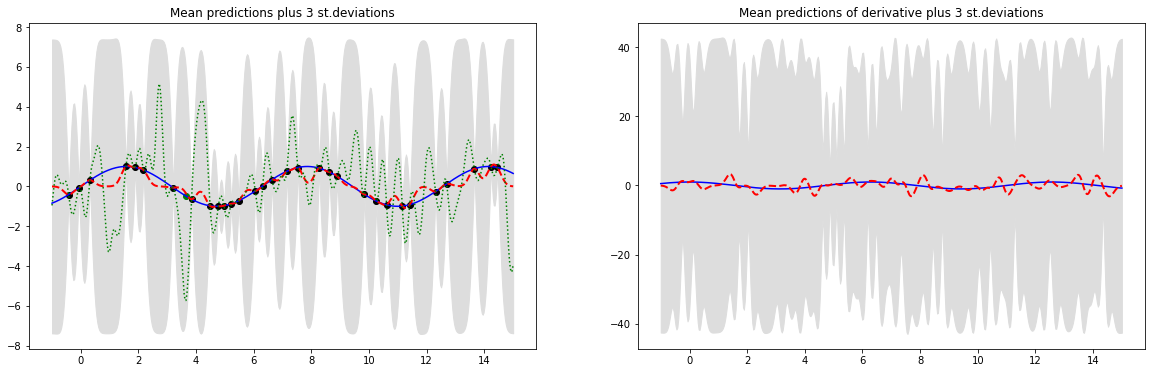

w:  [3.6492986]


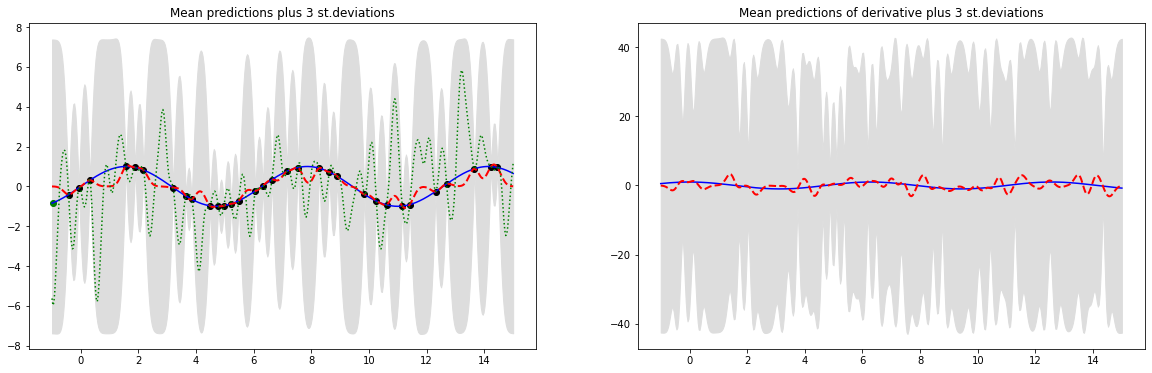

w:  [-0.96793587]


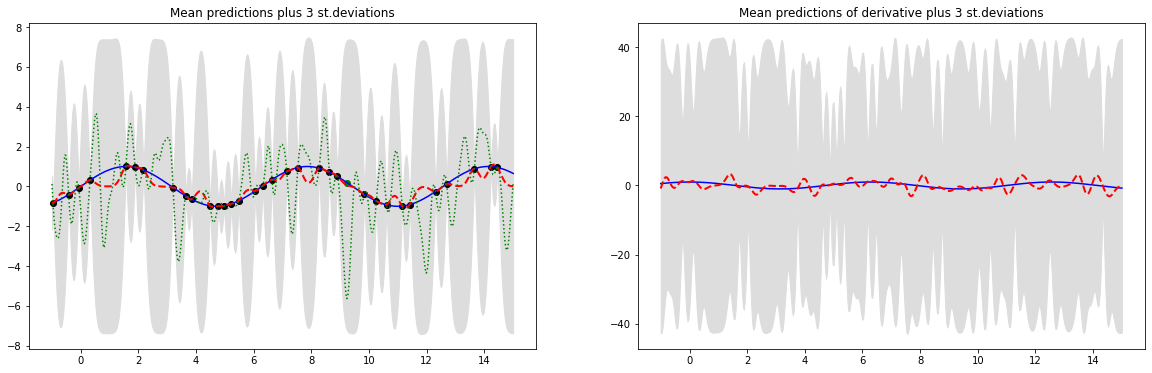

w:  [9.22845691]


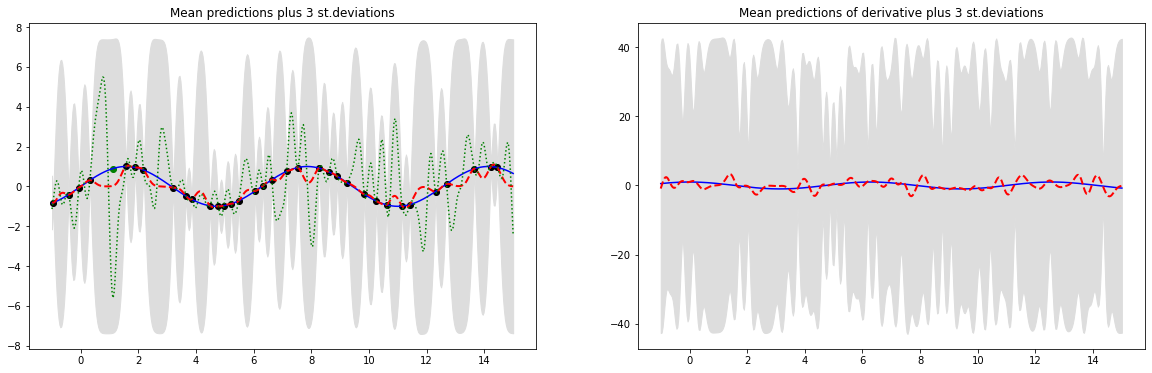

w:  [1.11623246]


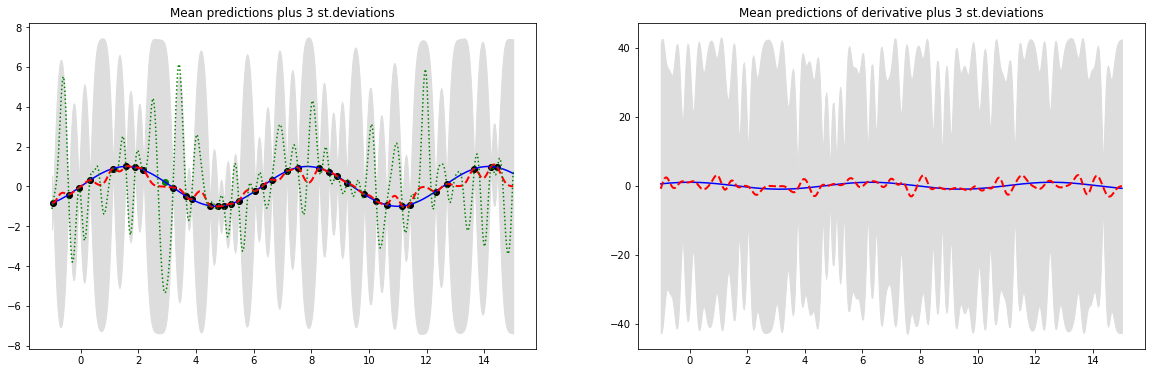

w:  [2.91182365]


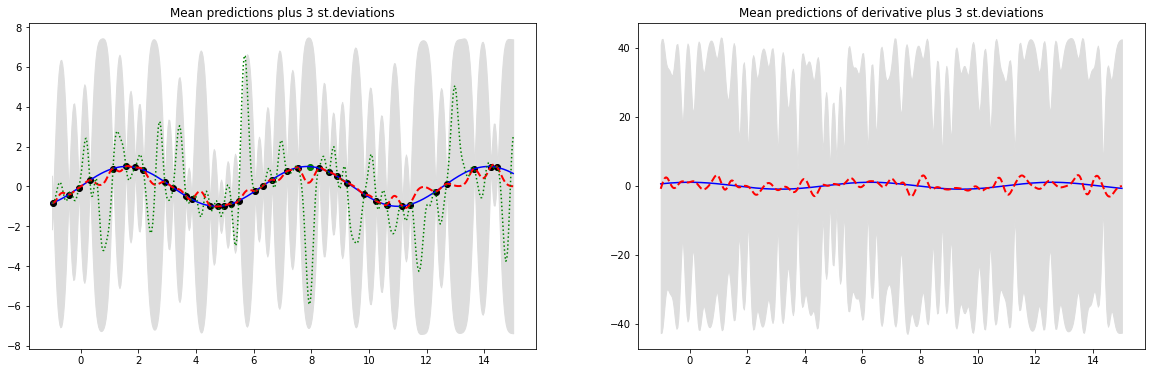

w:  [7.94589178]


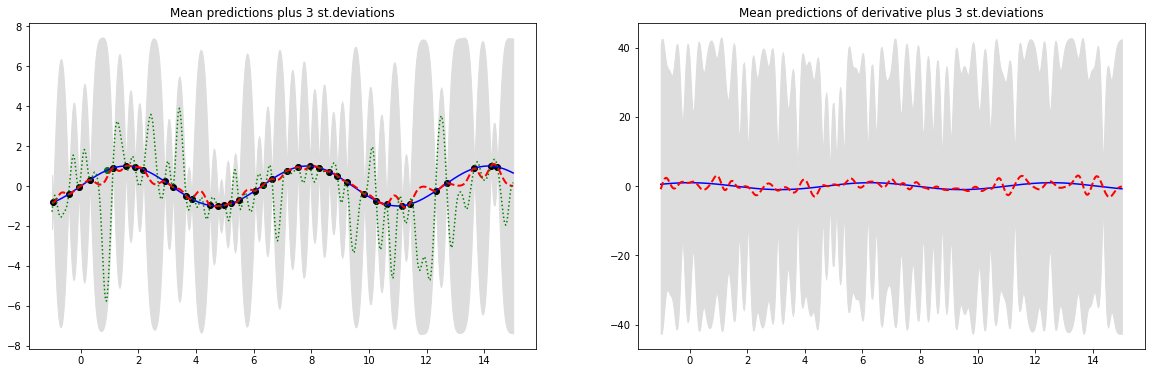

w:  [0.89178357]


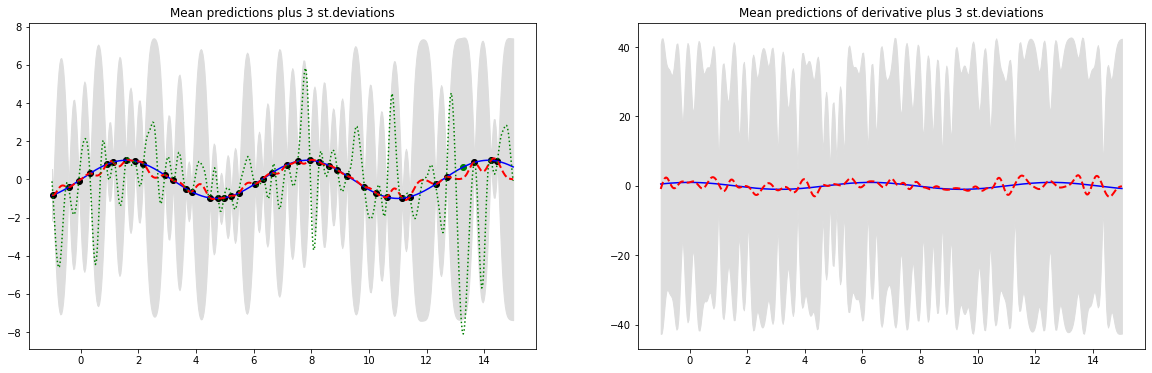

w:  [13.26853707]


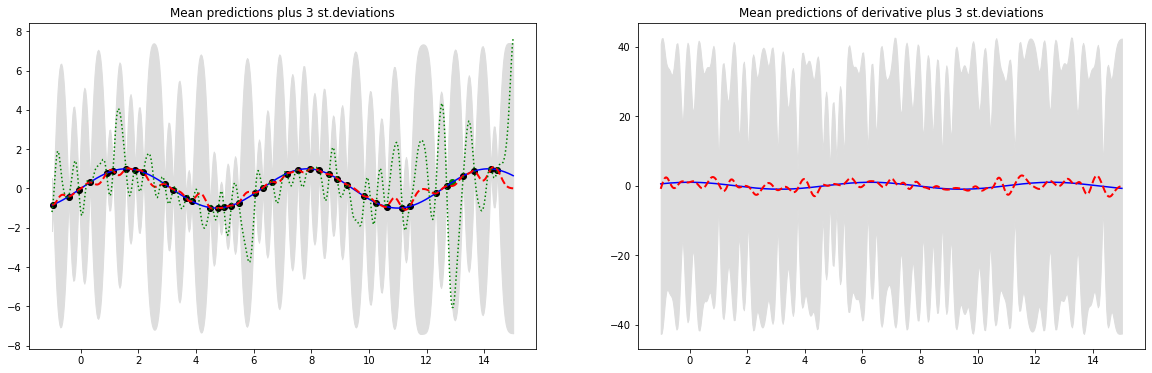

w:  [12.88376754]


In [25]:
gp.clear()
gp.set_hyper(ls, var)
gp.set_data(X, f(X))
gp.fit()

n_iter = 40
history = []

w = X[0].reshape(-1, 1)

for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    mu_grad = np.squeeze(mu_grad)
    s_grad = np.sqrt(np.diag(covar_grad))
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, dim)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'go')
    
    ax1.plot(Grid.flat, np.sin(Grid.flat), 'b-')
#     ax1.plot(Grid.flat, functions.Ackley_1().func(Grid), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")
    ax1.plot(Grid, mu, 'r--', lw=2)
    ax1.plot(Grid.flat, f_post, 'g:')
    ax1.set_title('Mean predictions plus 3 st.deviations')
#     ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
#     ax2.plot(Grid.flat, np.cos(Grid.flat) + 0.1, 'b-') 
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")
    ax2.plot(Grid.flat, approx_grad, 'b-')
    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
#     ax2.axis([-5, 15, -3, 3])
    
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('Result_Plots/' + filename)
    pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w, f(w))
    gp.fit()

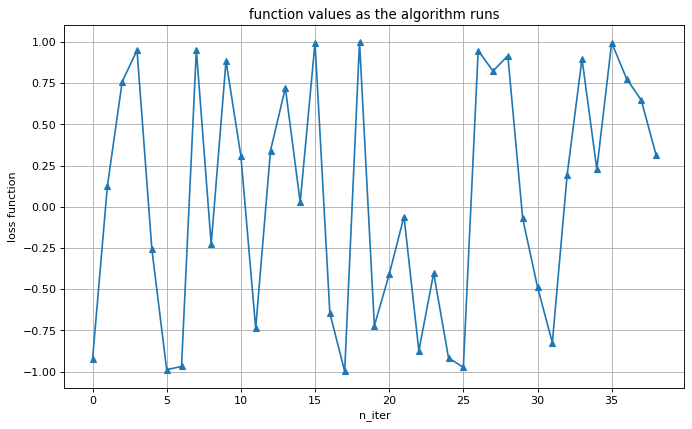

In [26]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [ ]:
# # Creates the .gif from the saved plots for the 2D_Plots dir.
# filenames = []
# for i in range(1, n_iter):
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     filenames.append(filename)

# frames=[]
# for filename in filenames:
#     frames.append(imageio.imread('Result_Plots/' + filename))
# exportname = 'Ackley_noise.gif'

# kargs = { 'duration': 0.5 }
# imageio.mimsave(exportname, frames, 'GIF', **kargs)